# CODE

In [1]:
# coding: utf-8
import numpy as np
from matplotlib import pyplot as plt
def orto(x):
    if np.dot(x,x) == 0:
        return 'No se puede: ese es el vector cero!'
    else:
        if 0 not in x:
            v1 = 1
            v2 = -(x[0]/x[1])
            v3 = 0
            #return np.array([v1,v2,v3])
        else:
            if x[0] == 0:
                if x[1] == 0:
                    v1 = 1
                    v2 = 0
                    v3 = 0
                else:
                    v1 = 0
                    v2 = 0
                    v3 = 1
            elif x[1] == 0:
                v1 = 0
                v2 = 1
                v3 = 0
            else:
                v1 = 0
                v2 = 0
                v3 = 1
        return np.array([v1,v2,v3])
    
#Funcion que regresa dos vectores; numpy arrays de 3D, ortogonales al vector de input x.
#Esto es, devuelven la base al espacio ortogonal definido por el vector x de entrada.
#@jit
def base_ort_nor(x):
    y = orto(x)
    v1 = y/np.linalg.norm(y)
    z = np.cross(x,v1)
    v2 = z/np.linalg.norm(z)
    return v1, v2


#Esta funcion genera un vector con distrubucion uniforme en las direcciones sobre un plano tangente a la esfera de radio R.
#@jit
def vector_des(v1,v2):
    na = 2*np.pi*np.random.rand()
    vn = v1*np.cos(na) + v2*np.sin(na)
    return vn/np.linalg.norm(vn)

R = 1.

#Normalizamos al vector de desplazamiento para que intersecte al vector de la nueva posicion de acuerdo con que el
#desplazamiento (s) sobre la esfera, sobre este arco de circulo maximo, sea el determinado por el movimiento browniano particular.
#@jit
def vector_q(x,s):
    q = (R)*np.tan(s/(R))
    return q*x

#Dados todos los datos anteriores, esta funcion actualiza la posicion de la particula.
#Lo que hace es que la mueve sobre el plano tangente a la esfera en la direccion predeterminada de tal suerte que el desplazamiento efectivo
#s sobre una geodesica de la esfera, se el deseado, y posteriormente la proyecta sobre la superficie de la esfera.
#@jit
def nuevo_r(r, vector_q):
    y = r + vector_q
    y = y/np.linalg.norm(y)
    return (R)*y

#funcion que incorpora el efecto de un campo externo



#Esta funcion ensambla todo lo anterior: como imput necesita una posicion inicial y un arco de desplazamiento
#Como output da un vector de posicion nuevo dada un tipo de desplazamiento.
#@jit
def actualiza(r,s):
    v1, v2 = base_ort_nor(r)
    pre_q = vector_des(v1,v2)
    q = vector_q(pre_q, s)
    return nuevo_r(r, q)




#Esta funcion actualiza la posicion de todos los elementos de una lista; particula brownianas.
#@jit


def act_n(lista, D, delta_t):
    l = []
    for v in lista:
        s = ese(D,delta_t)
        l.append(actualiza(v,s))
    return l



#Huella de la trayectoria
#La siguiente funcion hace una particion de la trayectoria sobre s en n pedazos y regresa
#una lista de los vectores de esas posiciones sobre la esfera.
#Usa al operador de rotacion.

#@jit
def b_steps_(ri,rf,n):
    l = [ri]
    r0 = ri
    lamb = (np.dot(ri,rf))/((np.linalg.norm(ri))*(np.linalg.norm(rf)))
    
    if abs(lamb) > 1:
        #print 'Is fucked up: there was a rounding '
        if lamb < 0:
            lamb = -1
        else:
            lamb = 1
    
    
    
    theta = np.arccos(lamb)
    #if theta < 1e17:
        #return l
    if theta == 0:
        return [ri,rf]
    
    else:

        normal = np.cross(ri, rf)/ np.linalg.norm(np.cross(ri,rf))
        for i in range(1,n + 1):
            #vi = rot_theta(r0, theta/n, normal)
            vi = rot_finita(r0, -normal, theta/n)
            l.append(vi)
            r0 = vi
        return l


#Operador de Rotacion
#Depende de los parametros r, el vector o punto que queremos rotar; theta el angulo de rotacion; n el vector que define el eje de rotacion y el signo de rotacion.


#@jit
def rot_theta(r, theta, u):
    x = np.array([np.cos(theta) + (u[0]*u[0])*(1 - np.cos(theta)), u[0]*u[1]*(1 - np.cos(theta)) - u[2]*np.sin(theta), u[0]*u[2]*(1 - np.cos(theta)) + u[1]*np.sin(theta)])
    y = np.array([u[1]*u[0]*(1 - np.cos(theta)) + u[2]*np.sin(theta), np.cos(theta) + u[1]*u[1]*(1 - np.cos(theta)), u[1]*u[2]*(1 - np.cos(theta)) - u[0]*np.sin(theta)])
    z = np.array([u[2]*u[0]*(1 - np.cos(theta)) - u[1]*np.sin(theta), u[2]*u[1]*(1 - np.cos(theta)) + u[0]*np.sin(theta), np.cos(theta) + u[2]*u[2]*(1 - np.cos(theta))])
    R = np.array([x,y,z])
    return np.dot(R, r)



#Transformacion de coordenada de esfericas a cartesianas.

#@jit
def trans_s_c(r,theta, phi):
    x = r*np.sin(theta)*np.cos(phi)
    y = r*np.sin(theta)* np.sin(phi)
    z = r*np.cos(theta)
    return x, y, z



def trans_c_s(x,y,z):
    r = np.sqrt(x**2 + y**2 + z**2)
    #print r
    cociente = z/r
    if abs(cociente) > 1:
        if cociente < 0:
            theta = np.arccos(-1.)
        else:
            theta = np.arccos(1.)
    else:
        
        theta = np.arccos(z/r)
    #Aqui hay un problema relevante: cada vez que y o x sean nulos, habra un problema
    #de indefinicion de operacion
    if x == 0.:
        if y == 0.:
            phi = 2*np.pi*np.random.rand()
    else:
        if x < 0:
            phi = np.arctan(y/x) + np.pi
        else:
            if y < 0:
                phi = np.arctan(y/x) + 2*np.pi
            else:
                
                phi = np.arctan(y/x)
    return r, theta, phi




#Base unitaria para las coordenadas esféricas
#@jit
def r_uni(theta, phi):
    x = np.sin(theta)*np.cos(phi)
    y = np.cos(theta)*np.cos(phi)
    z = np.cos(theta)
    return np.array([x,y,z])
#@jit
def theta_uni(theta, phi):
    x = np.cos(theta)*np.cos(phi)
    y = np.cos(theta)*np.sin(phi)
    z = -np.sin(theta)
    return np.array([x,y,z])
#@jit
def phi_uni(theta, phi):
    x = -np.sin(phi)
    y = np.cos(phi)
    z = 0
    return np.array([x,y,z])

#Función que normaliza los nombres para las animaciones de tal suerte que tenga el mismo número de
#digitos y se iteren en orden
#@jit
def nombre(s):
    diferencia = 4 - len(str(s))
    ceros = '' 
    for i in range(diferencia):
        ceros = ceros + '0'
    variable = ceros + str(s)
    return variable

#Varianza para una distribucion bigaussiana; difusion en 2D
#@jit
def var(D, delta_t):
    return 4*D*delta_t


#Arco de circulo maximo con distribucion normal alrededor de cero y una varianza dada por
#@jit
def ese(D,delta_t):
    return abs(np.random.normal(loc = 0., scale = np.sqrt(var(D,delta_t)),size = None))

#Funcion de rotacion finita
#@jit
def rot_finita(r_ini, N, Phi):
    n = N/np.linalg.norm(N)
    r_fin = np.cos(Phi)*r_ini + (np.dot(n,r_ini))*(1 - np.cos(Phi))*n + (np.sin(Phi))*(np.cross(r_ini,n))
    return r_fin


#Funcion que regresa una lista de n numpy arrays que son l
def Trayectoria(ri,rf,n):
    l = [ri]
    r0 = ri
    theta = np.arccos((np.dot(ri,rf))/((np.linalg.norm(ri))*(np.linalg.norm(rf))))
    N = np.cross(ri, rf)
    
    for i in range(1,n + 1):
        vi = rot_finita(r0, N, theta/n)
        l.append(vi)
        r0 = vi
    return l

#Collision_check es una función que, dada una trayectoria: una lista de vectores que
#pasan por puntos sucesivos de la trayectoria, verifica si alguna de estas posiciones
#interesecto a alguno de los obstáculos. En caso de que así sea, actualiza conforme una
#colision elastica. En caso de no intersectar a ningun obstaculo regresa una lista
#con dos vectores: posicion inicial y posicion final en ese orden.
#@jit
def penetrate_obs(lista_vect, lista_obs, size):
    metiches = []
    for obs in lista_obs:
        theta_omega = size
        r_omega = obs
        frontera = .2
        #metiches = []
        for v in lista_vect:
            tamanho = np.cos(theta_omega - frontera)
            if np.dot(v,r_omega) > tamanho:
                print('Penetro el mother fucker obstacle')
                metiches.append(v)
                
            else:
                continue
    #print 'no choco el mother fucker'
    #valor = False
    return metiches


#Esta funcion cuando es llamada grafia la posicion de las partoculas brownianas.
#sobre la superficie de una esfera sobre la que se esta difundiendo.
#@jit
def plot_particles(lista, vpolar, vazim, numero):
    from mpl_toolkits.mplot3d import axes3d
    from mpl_toolkits.mplot3d import Axes3D
    from matplotlib import cm

    #import matplotlib.pyplot as plt
    #import numpy as np
    from itertools import product, combinations
    fig = plt.figure(figsize=(8,8))
    ax = fig.gca(projection='3d')
    ax.set_aspect("equal")
    ax._axis3don = False

    



    #draw sphere
    R = 1
    u, v = np.mgrid[0:2*np.pi:50j, 0:np.pi:50j]
    x=R*np.cos(u)*np.sin(v)
    y=R*np.sin(u)*np.sin(v)
    z=R*np.cos(v)
    #ax.plot_surface(x, y, z, color="r", alpha = 0.15)

    ax.plot_surface(x, y, z, cmap=cm.YlGnBu_r,rstride=1, cstride=1, alpha = 0.10, linewidth = 0.10)
    ax.view_init(vpolar, vazim)
    
    
    #draw an arrow or a set of arrow
    #ax.quiver(0,0,1.5,0,0,1, length=0.5, arrow_length_ratio = .5, color = "b")
    #ax.quiver(1.5,0,0,1,0,0, length=0.5, arrow_length_ratio = .5, color ="g")
    #ax.quiver(0,1.5,0,0,1,0, length=0.5, arrow_length_ratio = .5, color ="r")
    #draw patch
    #u, v = np.mgrid[0:2*np.pi:50j, 0:(np.pi/7):50j]
    #x=R*np.cos(u)*np.sin(v)
    #y=R*np.sin(u)*np.sin(v)
    #z=R*np.cos(v)
    #ax.plot_surface(x, y, z, color="r", alpha = 0.25)    
    
    #draw points
    for p in lista:
        ax.scatter([p[0]],[p[1]],[p[2]],color="b",s=15, alpha = 0.25)
    
    fig.savefig('Sim_free_diff_Img{}.png'.format(nombre(numero)))
    #ax.view_init(80, 30)
    #plt.show()
    plt.close()

    
    
#@jit
def polo_n(n, R):
    l = []
    for i in range(n):
        l.append(np.array([0,0,R]))
    return l

#@jit
def particion_esfera(ccero, Nphi):
    Ntheta = int(4*np.pi/(ccero*Nphi))
    print('Ntheta', Ntheta, 'Nphi', Nphi, 'Ntheta*Nphi', Ntheta*Nphi)
    sigmaPhi = 2*np.pi/Nphi
    deltaphi = 2*np.pi/Nphi
    thetas = []
    phis = [0]
    cociente = ccero/sigmaPhi
    for i in range(Ntheta + 1):
        theta = np.arccos(1 - (i)*cociente)
        thetas.append(theta)
    for j in range(Nphi):
        phis.append(phis[j] + deltaphi)
    return thetas, phis

#@jit
def secuencia_part(tamini, Nfi, numero):
    l1, l2 = particion_esfera(4*np.pi/tamini, Nfi)
    particion = []
    for i in range(len(l2)):
        for j in range(len(l1)):
            x, y, z = trans_s_c(1, l1[j], l2[i])
            particion.append(np.array([x, y, z]))
            
    return plot_particles(particion, 45, 45, numero)

#Funcion que regresa las coordenadas del centro de dos arreglos para 
#las coordenadas theta y phi
#@jit
def coordenadas_centro(l1,l2):
    thetas_centro = []
    phis_centro = []
    for i in range(len(l1) - 1):
        theta_media = l1[i] + (l1[i + 1] - l1[i])/2.
        thetas_centro.append(theta_media)
    for j in range(len(l2) - 1):
        phi_media = l2[j] + (l2[j + 1] - l2[j])/2.
        phis_centro.append(phi_media)
    return thetas_centro, phis_centro

#@jit(nopython=True)
def secuencia_obs(N, Nfi, numero):
    l1_prima, l2_prima = particion_esfera(4*np.pi/N, Nfi)
    l1, l2 = coordenadas_centro(l1_prima, l2_prima)
    particion = []
    for i in range(len(l2)):
        for j in range(len(l1)):
            x, y, z = trans_s_c(1, l1[j], l2[i])
            particion.append(np.array([x, y, z]))
            
    print(len(particion))
    
    #return plot_particles(particion, 0, 0, numero)
    return particion


def plot_particle_traj_obs(lista_obstaculos, trayectoria,  vpolar, vazim, numero):
    from mpl_toolkits.mplot3d import axes3d
    from mpl_toolkits.mplot3d import Axes3D
    from matplotlib import cm

    #import matplotlib.pyplot as plt
    #import numpy as np
    from itertools import product, combinations
    fig = plt.figure(figsize=(20,10))
    ax = fig.gca(projection='3d')
    ax.set_aspect("equal")
    ax._axis3don = False
    

    



    #draw sphere
    R = 1
    u, v = np.mgrid[0:2*np.pi:50j, 0:np.pi:50j]
    x=R*np.cos(u)*np.sin(v)
    y=R*np.sin(u)*np.sin(v)
    z=R*np.cos(v)
    #ax.plot_surface(x, y, z, color="r", alpha = 0.15)

    ax.plot_surface(x, y, z, cmap=cm.YlGnBu_r,rstride=1, cstride=1, alpha = 0.10, linewidth = 0.15)
    ax.view_init(vpolar, vazim)
    #draw patch
    #u, v = np.mgrid[0:2*np.pi:50j, 0:(np.pi/7):50j]
    #x=R*np.cos(u)*np.sin(v)
    #y=R*np.sin(u)*np.sin(v)
    #z=R*np.cos(v)
    #ax.plot_surface(x, y, z, color="r", alpha = 0.25)
    
    
    
    #draw obstacles
    
    for p in lista_obstaculos:
        ax.scatter([p[0]],[p[1]],[p[2]], color="b", s=10, alpha = 0.2)
    
    #draw trajectory
    for p in trayectoria:
        ax.scatter([p[0]],[p[1]],[p[2]], color="k",s=20, alpha = 0.7)
    
    #Plot the x positive direction
    
    ax.quiver(1.5,0,0,1,0,0, length=0.5, arrow_length_ratio = .5)
    ax.quiver(0,1.5,0,0,1,0, length=0.5, arrow_length_ratio = .5)
    ax.quiver(0,0,1.5,0,0,1, length=0.5, arrow_length_ratio = .5)
    
    #fig.savefig('BS_24_Obs_test_01{}.png'.format(nombre(numero + 1)))
    #ax.view_init(80, 30)
    #plt.close()
    plt.show()

def obs_uniforme(N, R, size):
    
    list_obs = []
    omega = np.cos(size)
    while len(list_obs) < N:
        x, y, z = np.random.uniform(-1,1), np.random.uniform(-1,1), np.random.uniform(-1,1)
        v = np.array([x, y, z])
        norma = np.linalg.norm(v)
        if norma <= R:
            n = v/norma
            if not np.dot(n, np.array([0.,0.,1.]))/R > omega:
                list_obs.append(R*n)
    
    return list_obs    


def puntos_obs_j(r_omega, theta_omega, n):
    r , theta, phi = trans_c_s(r_omega[0],r_omega[1],r_omega[2])
    rp = rot_finita(r_omega, phi_uni(theta, phi), theta_omega)
    puntos_obs_j = [rp]
    for i in range(1,n):
        x = rot_finita(rp, r_omega, 2*np.pi/n)
        puntos_obs_j.append(x)
        rp = x
    return puntos_obs_j



def puntos_obs(lista_obstaculos, size):
    mis_obs = []
    for i in range(len(lista_obstaculos)):
        a = lista_obstaculos[i]
        b = size
        mis_obs = mis_obs + puntos_obs_j(a,b,100)
    return mis_obs
#Collision_check es una función que, dada una trayectoria: una lista de vectores que
#pasan por puntos sucesivos de la trayectoria, verifica si alguna de estas posiciones
#interesecto a alguno de los obstáculos. En caso de que así sea, actualiza conforme una
#colision elastica. En caso de no intersectar a ningun obstaculo regresa una lista
#con dos vectores: posicion inicial y posicion final en ese orden.

def penetrate_obs(lista_vect, lista_obs, size):
    metiches = []
    for obs in lista_obs:
        r_omega, theta_omega = obs, size
        #frontera = .2
        #metiches = []
        for v in lista_vect:
            tamanho = np.cos(theta_omega)
            if np.dot(v,r_omega) >= tamanho:
                #print 'Penetro el mother fucker obstacle'
                metiches.append(v)
                
            else:
                continue
    #print 'no choco el mother fucker'
    #valor = False
    return metiches
    

def check_collision(lista_vect, lista_obs, size):
    for obs in lista_obs:
        r_omega, theta_omega = obs, size 
        for v in lista_vect:
            tamanho = np.cos(theta_omega)
            if np.dot(v,r_omega) > tamanho:
                return  True
            else:
                continue
    return False
    

def vector_q(x,s):
    q = np.tan(s)
    return q*x

#Distribución en el polo sur

def polo_s(n, R):
    l = []
    for i in range(n):
        l.append(np.array([0,0,-R]))
    return l

#Dsitribución en el ecuador

def dist_ecuador(n):
    l = []
    for i in range(n):
        x, y, z = trans_s_c(1.,np.pi/2, np.random.uniform(0,2*np.pi))
        l.append(np.array([x,y,z]))
    return l



In [2]:
def tangent_space(x1,x2,xo):
    np_prima = np.cross(np.cross(xo, x1), x1)
    nor_p = np_prima/np.linalg.norm(np_prima)
    up_prima = np.cross(np.cross(x1, x2), x1)
    up = up_prima/np.linalg.norm(up_prima)
    tp_prima = np.cross(x1, nor_p)
    tp = tp_prima/np.linalg.norm(tp_prima)
    y = (np.dot(up,tp))*tp - (np.dot(up, nor_p))*nor_p
    v_rot_prima = np.cross(x1, y)
    v_rot = v_rot_prima/np.linalg.norm(v_rot_prima)
    return v_rot

In [3]:
def uniform_inside_omega(N, R, size):

    list_obs = []
    omega = np.cos(size)
    while len(list_obs) < N:
        x, y, z = np.random.uniform(-1,1), np.random.uniform(-1,1), np.random.uniform(-1,1)
        v = np.array([x, y, z])
        norma = np.linalg.norm(v)
        if norma <= R:
            n = v/norma
            if not np.dot(n, np.array([0.,0.,1.]))/R < omega:
                list_obs.append(R*n)
    
    return list_obs   

# COLLISIONS OBSTACLES

In [4]:
def collision_check(Lv, Lo, size):
    if len(Lv) == 1:
        return Lv[0], Lv[0], 0
    
    elif len(Lv) == 2:
        sproduct = np.dot(Lv[0], Lv[1])
        if abs(sproduct) > 1:
            if sproduct < 0:
                sproduct = -1.
            else:
                sproduct = 1.
                
        alpha = np.arccos(sproduct)
        for obs in Lo:
            r_o = obs
            if np.dot(Lv[1],r_o) > np.cos(size):
                v_rot = tangent_space(Lv[0], Lv[1], r_o)
                x_final = rot_finita(Lv[1], -v_rot, alpha)
                return Lv[1], x_final, 0
    else:
        for k in range(1,len(Lv)):
            for obs in Lo:
                r_o = obs
                if np.dot(Lv[k],r_o) > np.cos(size):
                    v_rot = tangent_space(Lv[0], Lv[k], r_o)
                    
                    if k == len(Lv) - 1:
                        sproduct = np.dot(Lv[k-1], Lv[k])
                        if abs(sproduct) > 1:
                            if sproduct < 0:
                                sproduct = -1.
                        else:
                            sproduct = 1.
                        
                        
                    
                    else:
                        sproduct = np.dot(Lv[k], Lv[-1])
                        if abs(sproduct) > 1:
                            if sproduct < 0:
                                sproduct = -1.
                            else:
                                sproduct = 1.
                    alpha = np.arccos(sproduct)
                    
                    x_final = rot_finita(Lv[k], -v_rot, alpha)
                    return Lv[k], x_final, k
        return Lv[0], Lv[-1], 0

# EXTERNAL FIELDS

In [5]:
#Definimos las funciones para el campo exterior
#q = (R)*np.tan(s/(R))
def nuevo_r_field(r, vector_q, field):
    #nfield = np.tan(field)
    xf = np.linalg.norm(field)
    if xf == 0:
        nfield = 0
    else:
        fvecuni = field/xf
        nfield = np.tan(xf)*fvecuni
    #y = r + vector_q + nfield
    y = r + vector_q + nfield
    y = y/np.linalg.norm(y)
    return y

def field_theta(ri, v0):
    r, theta, phi = trans_c_s(ri[0],ri[1],ri[2])
    #(-2*v0*np.sin(2*theta)*theta_uni(theta, phi))
    #(-v0*np.sin(phi)*phi_uni(theta, phi))
    field = -v0*theta_uni(theta, phi) + ((v0 + theta)**2)*phi_uni(theta, phi)
    return field

def actualiza_field_theta(r,s,v0):
    v1, v2 = base_ort_nor(r)
    pre_q = vector_des(v1,v2)
    q = vector_q(pre_q, s)
    return nuevo_r_field(r, q, field_theta(r,v0))
    #return nuevo_r_field(r, pre_q, field_theta(r,v0))


def act_n_field(lista, v0):
    l = []
    for v in lista:
        s = ese(D,dt)
        l.append(actualiza_field_theta(v, s, v0))
    return l


In [6]:
def coeficiente(n,N,D,dt):
    #N es el numero de pasos, por lo que el tiempo total transcurrido hasta ese momento es
    t = dt * N
    return ((2*n + 1.)/(4*np.pi)) * np.exp(-n*(n + 1)*D*t)

In [7]:
def distribucion(theta, N, orden,D,dt):
    #lista = []
    c = np.zeros(orden)
    for n in range(orden):
        c[n] = coeficiente(n,N,D,dt)
        #lista.append(coeficiente(n,N)*np.polynomial.legendre.legval(np.cos(theta), c))
    lista = np.polynomial.legendre.legval(np.cos(theta), c)
    #print lista
    #return sum(lista)
    return lista

In [8]:
def distribucion_weighted(theta, N, orden, D, dt):
    #lista = []
    c = np.zeros(orden)
    for n in range(orden):
        c[n] = coeficiente(n, N, D, dt)
        #lista.append(coeficiente(n,N)*np.polynomial.legendre.legval(np.cos(theta), c))
    lista = np.polynomial.legendre.legval(np.cos(theta), c)*np.sin(theta)*2*np.pi
    #print lista
    #return sum(lista)
    return lista

In [9]:
%matplotlib inline

In [10]:
%config InlineBackend.figure_format ='retina'

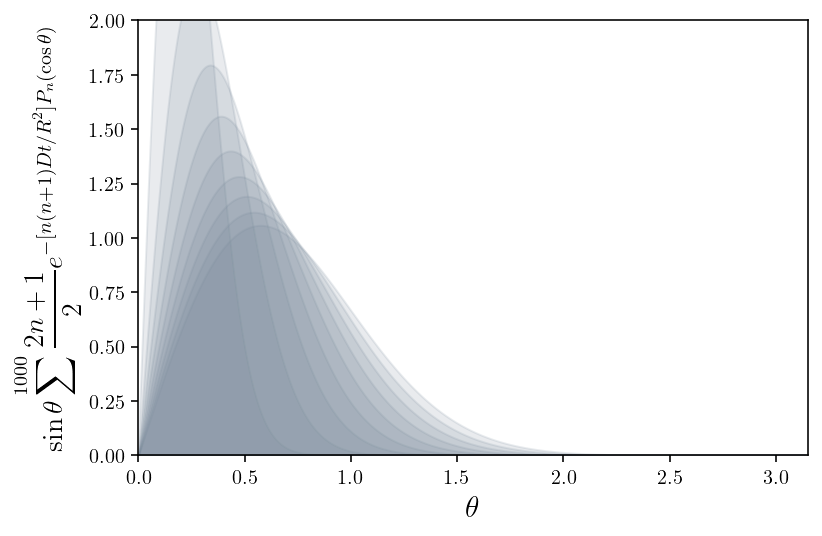

In [12]:
#D es el coeficiente de difusion, R el radio de la esfera y dt el tamaño del paso.
D = 1e-1
R = 1.
dt = np.log(2)*1e-3
theta = np.linspace(0.0,np.pi,1000)

for i in range(1,10):
    #fig = plt.figure()
    plt.rc('text', usetex = True)
    
    plt.fill_between(theta, distribucion_weighted(theta,280*i,1000,D,dt) ,y2 = 0, color = '#778899', alpha = .16)
    #plt.title("t = {} pasos".format(i))
    plt.ylim(0, 2)
    plt.xlim(0,np.pi+0.01)
    plt.xlabel(r"$\theta$ " , fontsize = 15)
    plt.ylabel(r"$\displaystyle \sin{\theta} \sum^{1000} \frac{2n + 1}{2}e^{-[n(n+1)Dt/R^2]P_{n}(\cos{\theta})}$", fontsize = 14)
plt.show()
#plt.savefig('Chingona_Weighted_01.pdf', dpi = 600, bbox_inches = 'tight')

In [433]:
def plot_yuxt_num_ana(D,dt, rango, step):
    #D es el coeficiente de difusion, R el radio de la esfera y dt el tamaño del paso.
    
    theta = np.linspace(0.0,np.pi,1000)

    for i in rango:
        #fig = plt.figure()
        plt.rc('text', usetex = True)
        #plt.fill_between(theta, distribucion_weighted(theta, (i * step),1000,D) ,y2 = 0, 
        #                 color = '#778899', alpha = (.2/(1*i) ))
        plt.plot(theta, distribucion_weighted(theta, (i * step),1000,D,dt), 
                         color = 'k', alpha = (.6 ), linewidth=1)
        #plt.title("t = {} pasos".format(i))
        plt.ylim(0, 3)
        plt.xlim(0,np.pi+0.01)
        plt.xlabel(r"$\theta$ " , fontsize = 15)
        #plt.ylabel(r"$\displaystyle \sin{\theta} \sum^{500} \frac{2n + 1}{2}\exp{-[n(n+1)Dt/R^2]P_{n}(\cos{\theta})}$", fontsize = 14)
    plt.show()
    #plt.savefig('Chingona_Weighted_01.pdf', dpi = 600, bbox_inches = 'tight')

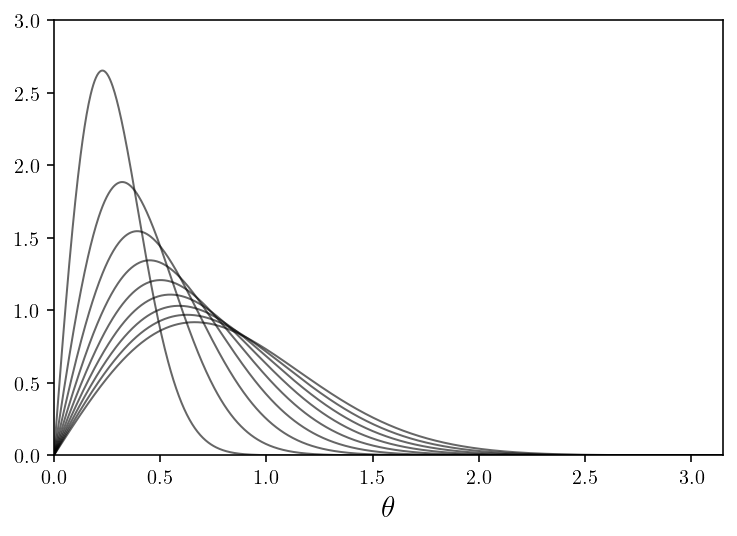

In [434]:
plot_yuxt_num_ana(1e-1, np.log(2)*1e-3, range(1,10), 380)

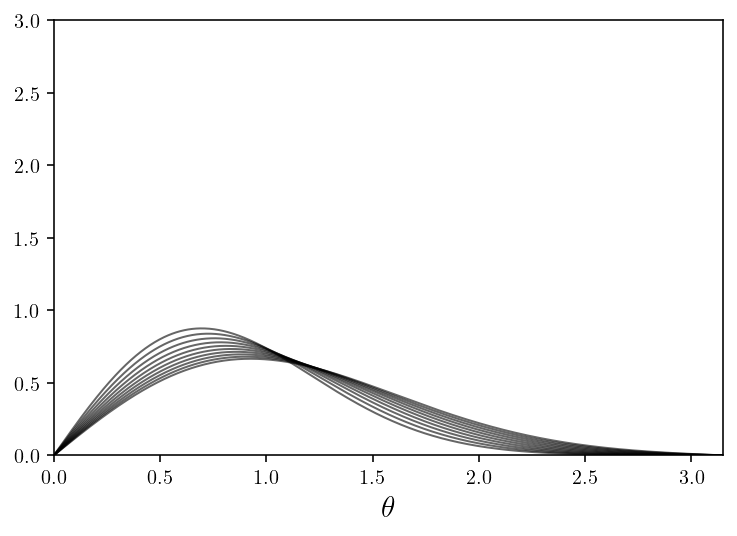

In [435]:
plot_yuxt_num_ana(1e-1, np.log(2)*1e-3, range(10,20), 380)

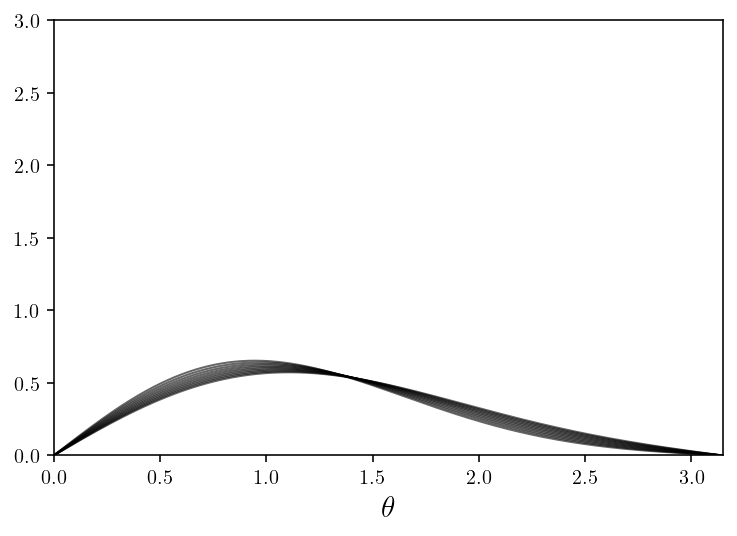

In [436]:
plot_yuxt_num_ana(1e-1, np.log(2)*1e-3, range(20,30), 380)

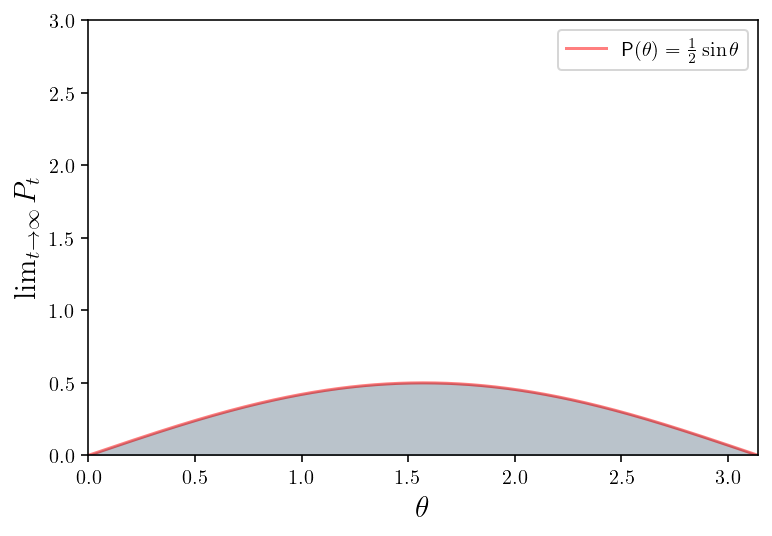

In [161]:
#plt.rc('text', usetex = True)
y = (1/(2.))*np.ones(len(theta))*np.sin(theta)

#plt.rc('text', usetex=True)
#plt.rc('font', family='serif')
plt.plot(theta, y, 'r', label = r'$\mbox{P}(\theta) = \frac{1}{2} \sin{\theta}$', alpha = 0.5)
plt.fill_between(theta, y ,y2 = 0, color = '#778899', alpha = .50)
plt.xlabel(r'$\theta$', fontsize = 15)
plt.ylabel(r'$\lim_{t \rightarrow \infty} P_{t}$', fontsize = 15)
plt.xlim(0,np.pi)
plt.ylim(0,3)
plt.legend(loc=1)
plt.show()

#plt.savefig('Chingona_Weighted_02.pdf', dpi = 600, bbox_inches = 'tight')

#plt.title(r'\displaystyle \lim_{t\rightarrow \infty} \sum_{i=0}^{\infty} #
#\frac{2n + 1}{4\pi}\exp{\left [-n(n + 1)Dt/R^2 \right]}P_{n}(\cos(\theta))')

# SIMULACIONES

In [12]:
%pwd

'/Users/adrianovaldesgomez/Documents/Adriano_Programming'

In [23]:
!mkdir Animacion_Free_Diff_01

In [24]:
%ls

Adriano_Masters_Code_0416_01.py
Analytic_vs_Numeric.ipynb
Animacion_Free_Diff_01/
AntiJoin.ipynb
Bi_Stable_Field_Images0000.png
Dpole_North_ini_dist_Hist_Phi_t.txt
Dpole_North_ini_dist_Hist_Theta_t.txt
Dpole_North_ini_dist_Mean_Theta_t.txt
Dpole_North_ini_dist_Mean_phi_t.txt
Dpole_North_ini_dist_Var_Phi_t.txt
Dpole_North_ini_dist_Var_Theta_t.txt
Julia_Tests.ipynb
Normalied_Histograms.ipynb
OBS_SIM_Test_01/
Obstacles Intersection.ipynb
Obstacles_Simulations_UB_Density_01.ipynb
Playing fool Py3.ipynb
Potentials.ipynb
R_Anaconda_Environment_test.ipynb
SHY42_Animation_01.avi
Test_01.ipynb
UnsuperviseLearning.ipynb
Valdes_Sanders_2016.ipynb
Y10.ipynb
Y10_28_10_2017/
Y20.ipynb
Y20_Hist_Theta_t0.png
Y20_Hist_Theta_tinfty.png
Y30.ipynb
Y30_29112017/
Y30_Hist_Phi_t.txt
Y30_Hist_Phi_t0.png
Y30_Hist_Phi_tinfty.png
Y30_Hist_Theta_t.txt
Y30_Hist_Theta_t0.png
Y30_Hist_Theta_t2.txt
Y30_Hist_Theta_tinfty.png
Y30_Mean_Theta_t.txt
Y30_Mean_Theta_t2.txt
Y30_Mean_phi_t.txt
Y30_Var_Phi_t.txt
Y30_Var_Theta_

In [12]:
%cd Animacion_Free_Diff_01/

/Users/adrianovaldesgomez/Documents/Adriano_Programming/Animacion_Free_Diff_01


## Backbone

In [65]:
D = 1e-1
dt = np.log(2)*1e-1
#v0 = 2.5*np.sqrt(2*D)*dt
#dist_uni = obs_uniforme(800, 1., 0)
dist_ini = polo_n(600,1.)
plot_particles(dist_ini,0, 0, 0)
rs = dist_uni
for i in range(2000):
         
        nuevas_pos = act_n(rs, v0,dt)
        plot_particles(nuevas_pos, 0, 0, i + 1)
        rs = nuevas_pos

In [67]:
!mencoder "mf://*.png" -o Sim_free_diff_01.avi -ovc lavc -lavcopts vcodec=msmpeg4v2:autoaspect:vbitrate=2160000:mbd=2:keyint=132:vqblur=1.0:cmp=2:subcmp=2:dia=2:o=mpv_flags=+mv0:last_pred=3 -fps 15

MEncoder 1.3.0-4.2.1 (C) 2000-2016 MPlayer Team
224 audio & 451 video codecs
success: format: 16  data: 0x0 - 0x0
MF file format detected.
[mf] search expr: *.png
[mf] number of files: 2001 (16008)
[demux_mf] file type was not set! trying 'type=png'...
VIDEO:  [MPNG]  0x0  24bpp  25.000 fps    0.0 kbps ( 0.0 kbyte/s)
[V] filefmt:16  fourcc:0x474E504D  size:0x0  fps:25.000  ftime:=0.0400
Input fps will be interpreted as 15.000 instead.
libavcodec version 57.24.102 (internal)
Opening video filter: [expand osd=1]
Expand: -1 x -1, -1 ; -1, osd: 1, aspect: 0.000000, round: 1
Opening video decoder: [ffmpeg] FFmpeg's libavcodec codec family
Selected video codec: [ffpng] vfm: ffmpeg (FFmpeg PNG)
Could not find matching colorspace - retrying with -vf scale...
Opening video filter: [scale]
Movie-Aspect is undefined - no prescaling applied.
[swscaler @ 0x1095ee410]bicubic scaler, from rgba to yuv420p using MMXEXT
videocodec: libavcodec (576x576 fourcc=3234504d [MP42])
[VE_LAVC] High quality encod

Pos:   2.7s     40f ( 1%)  0.00fps Trem:   0min   1mb  A-V:0.000 [56:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:   2.7s     41f ( 2%)  0.00fps Trem:   0min   1mb  A-V:0.000 [56:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:   2.8s     42f ( 2%)  0.00fps Trem:   0min   1mb  A-V:0.000 [56:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:   2.9s     43f ( 2%)  0.00fps Trem:   0min   1mb  A-V:0.000 [56:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:   2.9s     44f ( 2%)  0.00fps Trem:   0min   1mb  A-V:0.000 [56:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:   3.0s     45f ( 2%)  0.00fps Trem:   0min   1mb  A-V:0.000 [56:0]
[msmpeg4v2 @ 

Pos:   5.7s     85f ( 4%) 48.46fps Trem:   0min   1mb  A-V:0.000 [59:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:   5.7s     86f ( 4%) 48.67fps Trem:   0min   1mb  A-V:0.000 [60:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:   5.8s     87f ( 4%) 48.93fps Trem:   0min   1mb  A-V:0.000 [60:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:   5.9s     88f ( 4%) 49.16fps Trem:   0min   1mb  A-V:0.000 [60:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:   5.9s     89f ( 4%) 49.33fps Trem:   0min   1mb  A-V:0.000 [60:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:   6.0s     90f ( 4%) 49.42fps Trem:   0min   1mb  A-V:0.000 [60:0]
[msmpeg4v2 @ 

Pos:   8.9s    133f ( 6%) 55.95fps Trem:   0min   1mb  A-V:0.000 [73:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:   8.9s    134f ( 6%) 55.97fps Trem:   0min   1mb  A-V:0.000 [73:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:   9.0s    135f ( 6%) 56.09fps Trem:   0min   1mb  A-V:0.000 [73:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:   9.1s    136f ( 6%) 56.22fps Trem:   0min   1mb  A-V:0.000 [74:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:   9.1s    137f ( 6%) 56.38fps Trem:   0min   1mb  A-V:0.000 [74:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:   9.2s    138f ( 6%) 56.49fps Trem:   0min   1mb  A-V:0.000 [74:0]
[msmpeg4v2 @ 

Pos:  11.9s    178f ( 8%) 59.95fps Trem:   0min   1mb  A-V:0.000 [81:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  11.9s    179f ( 8%) 60.05fps Trem:   0min   1mb  A-V:0.000 [81:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  12.0s    180f ( 8%) 60.04fps Trem:   0min   1mb  A-V:0.000 [81:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  12.1s    181f ( 9%) 60.11fps Trem:   0min   1mb  A-V:0.000 [82:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  12.1s    182f ( 9%) 60.21fps Trem:   0min   1mb  A-V:0.000 [82:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  12.2s    183f ( 9%) 60.30fps Trem:   0min   1mb  A-V:0.000 [82:0]
[msmpeg4v2 @ 

Pos:  14.9s    224f (11%) 62.48fps Trem:   0min   1mb  A-V:0.000 [91:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  15.0s    225f (11%) 62.53fps Trem:   0min   1mb  A-V:0.000 [92:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  15.1s    226f (11%) 62.60fps Trem:   0min   1mb  A-V:0.000 [92:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  15.1s    227f (11%) 62.67fps Trem:   0min   1mb  A-V:0.000 [92:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  15.2s    228f (11%) 62.76fps Trem:   0min   1mb  A-V:0.000 [93:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  15.3s    229f (11%) 62.72fps Trem:   0min   1mb  A-V:0.000 [93:0]
[msmpeg4v2 @ 

Pos:  18.1s    272f (13%) 64.64fps Trem:   0min   1mb  A-V:0.000 [106:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  18.2s    273f (13%) 64.68fps Trem:   0min   1mb  A-V:0.000 [107:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  18.3s    274f (13%) 64.74fps Trem:   0min   1mb  A-V:0.000 [107:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  18.3s    275f (13%) 64.80fps Trem:   0min   1mb  A-V:0.000 [107:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  18.4s    276f (13%) 64.83fps Trem:   0min   1mb  A-V:0.000 [107:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  18.5s    277f (13%) 64.84fps Trem:   0min   1mb  A-V:0.000 [108:0]
[msmpeg

Pos:  21.3s    320f (15%) 66.24fps Trem:   0min   1mb  A-V:0.000 [116:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  21.4s    321f (16%) 66.24fps Trem:   0min   1mb  A-V:0.000 [116:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  21.5s    322f (16%) 66.28fps Trem:   0min   1mb  A-V:0.000 [117:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  21.5s    323f (16%) 66.32fps Trem:   0min   1mb  A-V:0.000 [117:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  21.6s    324f (16%) 66.38fps Trem:   0min   1mb  A-V:0.000 [117:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  21.7s    325f (16%) 66.35fps Trem:   0min   1mb  A-V:0.000 [117:0]
[msmpeg

Pos:  24.5s    368f (18%) 67.39fps Trem:   0min   2mb  A-V:0.000 [126:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  24.6s    369f (18%) 67.40fps Trem:   0min   2mb  A-V:0.000 [127:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  24.7s    370f (18%) 67.41fps Trem:   0min   2mb  A-V:0.000 [127:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  24.7s    371f (18%) 67.44fps Trem:   0min   2mb  A-V:0.000 [127:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  24.8s    372f (18%) 67.42fps Trem:   0min   2mb  A-V:0.000 [127:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  24.9s    373f (18%) 67.45fps Trem:   0min   2mb  A-V:0.000 [127:0]
[msmpeg

Pos:  27.7s    416f (20%) 68.22fps Trem:   0min   2mb  A-V:0.000 [138:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  27.8s    417f (20%) 68.24fps Trem:   0min   2mb  A-V:0.000 [139:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  27.9s    418f (20%) 68.26fps Trem:   0min   2mb  A-V:0.000 [139:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  27.9s    419f (20%) 68.29fps Trem:   0min   2mb  A-V:0.000 [139:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  28.0s    420f (20%) 68.30fps Trem:   0min   2mb  A-V:0.000 [139:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  28.1s    421f (21%) 68.33fps Trem:   0min   2mb  A-V:0.000 [139:0]
[msmpeg

Pos:  30.7s    461f (23%) 68.07fps Trem:   0min   2mb  A-V:0.000 [149:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  30.8s    462f (23%) 68.09fps Trem:   0min   2mb  A-V:0.000 [149:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  30.9s    463f (23%) 68.08fps Trem:   0min   2mb  A-V:0.000 [149:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  30.9s    464f (23%) 68.09fps Trem:   0min   2mb  A-V:0.000 [149:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  31.0s    465f (23%) 68.11fps Trem:   0min   2mb  A-V:0.000 [150:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  31.1s    466f (23%) 68.14fps Trem:   0min   2mb  A-V:0.000 [150:0]
[msmpeg

Pos:  33.7s    506f (25%) 68.36fps Trem:   0min   2mb  A-V:0.000 [159:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  33.8s    507f (25%) 68.37fps Trem:   0min   2mb  A-V:0.000 [159:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  33.9s    508f (25%) 68.36fps Trem:   0min   2mb  A-V:0.000 [160:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  33.9s    509f (25%) 68.39fps Trem:   0min   2mb  A-V:0.000 [160:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  34.0s    510f (25%) 68.39fps Trem:   0min   2mb  A-V:0.000 [160:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  34.1s    511f (25%) 68.42fps Trem:   0min   2mb  A-V:0.000 [160:0]
[msmpeg

Pos:  36.8s    552f (27%) 67.91fps Trem:   0min   2mb  A-V:0.000 [171:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  36.9s    553f (27%) 67.89fps Trem:   0min   2mb  A-V:0.000 [171:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  36.9s    554f (27%) 67.84fps Trem:   0min   2mb  A-V:0.000 [171:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  37.0s    555f (27%) 67.84fps Trem:   0min   2mb  A-V:0.000 [171:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  37.1s    556f (27%) 67.85fps Trem:   0min   2mb  A-V:0.000 [171:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  37.1s    557f (27%) 67.86fps Trem:   0min   2mb  A-V:0.000 [172:0]
[msmpeg

Pos:  39.9s    598f (29%) 67.46fps Trem:   0min   2mb  A-V:0.000 [180:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  39.9s    599f (29%) 67.45fps Trem:   0min   2mb  A-V:0.000 [180:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  40.0s    600f (29%) 67.44fps Trem:   0min   2mb  A-V:0.000 [180:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  40.1s    601f (30%) 67.31fps Trem:   0min   2mb  A-V:0.000 [181:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  40.1s    602f (30%) 67.28fps Trem:   0min   2mb  A-V:0.000 [181:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  40.2s    603f (30%) 67.10fps Trem:   0min   2mb  A-V:0.000 [181:0]
[msmpeg

Pos:  42.9s    643f (32%) 67.06fps Trem:   0min   3mb  A-V:0.000 [189:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  42.9s    644f (32%) 67.01fps Trem:   0min   3mb  A-V:0.000 [189:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  43.0s    645f (32%) 66.99fps Trem:   0min   3mb  A-V:0.000 [190:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  43.1s    646f (32%) 66.98fps Trem:   0min   3mb  A-V:0.000 [190:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  43.1s    647f (32%) 66.97fps Trem:   0min   3mb  A-V:0.000 [190:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  43.2s    648f (32%) 66.98fps Trem:   0min   3mb  A-V:0.000 [190:0]
[msmpeg

Pos:  45.9s    689f (34%) 67.06fps Trem:   0min   3mb  A-V:0.000 [199:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  46.0s    690f (34%) 67.04fps Trem:   0min   3mb  A-V:0.000 [199:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  46.1s    691f (34%) 67.04fps Trem:   0min   3mb  A-V:0.000 [200:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  46.1s    692f (34%) 67.04fps Trem:   0min   3mb  A-V:0.000 [200:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  46.2s    693f (34%) 67.00fps Trem:   0min   3mb  A-V:0.000 [200:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  46.3s    694f (34%) 66.98fps Trem:   0min   3mb  A-V:0.000 [200:0]
[msmpeg

Pos:  48.9s    734f (36%) 66.73fps Trem:   0min   3mb  A-V:0.000 [208:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  49.0s    735f (36%) 66.75fps Trem:   0min   3mb  A-V:0.000 [208:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  49.1s    736f (36%) 66.76fps Trem:   0min   3mb  A-V:0.000 [208:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  49.1s    737f (36%) 66.76fps Trem:   0min   3mb  A-V:0.000 [209:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  49.2s    738f (36%) 66.76fps Trem:   0min   3mb  A-V:0.000 [209:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  49.3s    739f (36%) 66.77fps Trem:   0min   3mb  A-V:0.000 [209:0]
[msmpeg

Pos:  52.1s    781f (39%) 67.14fps Trem:   0min   3mb  A-V:0.000 [217:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  52.1s    782f (39%) 67.15fps Trem:   0min   3mb  A-V:0.000 [218:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  52.2s    783f (39%) 67.17fps Trem:   0min   3mb  A-V:0.000 [218:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  52.3s    784f (39%) 67.17fps Trem:   0min   3mb  A-V:0.000 [218:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  52.3s    785f (39%) 67.17fps Trem:   0min   3mb  A-V:0.000 [218:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  52.4s    786f (39%) 67.19fps Trem:   0min   3mb  A-V:0.000 [219:0]
[msmpeg

Pos:  55.3s    829f (41%) 67.62fps Trem:   0min   3mb  A-V:0.000 [227:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  55.3s    830f (41%) 67.62fps Trem:   0min   3mb  A-V:0.000 [228:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  55.4s    831f (41%) 67.63fps Trem:   0min   3mb  A-V:0.000 [228:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  55.5s    832f (41%) 67.64fps Trem:   0min   3mb  A-V:0.000 [228:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  55.5s    833f (41%) 67.65fps Trem:   0min   3mb  A-V:0.000 [228:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  55.6s    834f (41%) 67.66fps Trem:   0min   3mb  A-V:0.000 [228:0]
[msmpeg

Pos:  58.4s    876f (43%) 67.98fps Trem:   0min   3mb  A-V:0.000 [237:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  58.5s    877f (43%) 67.98fps Trem:   0min   3mb  A-V:0.000 [237:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  58.5s    878f (43%) 67.99fps Trem:   0min   3mb  A-V:0.000 [237:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  58.6s    879f (43%) 68.01fps Trem:   0min   3mb  A-V:0.000 [237:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  58.7s    880f (43%) 68.02fps Trem:   0min   3mb  A-V:0.000 [238:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  58.7s    881f (44%) 68.04fps Trem:   0min   3mb  A-V:0.000 [238:0]
[msmpeg

Pos:  61.6s    924f (46%) 68.46fps Trem:   0min   3mb  A-V:0.000 [247:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  61.7s    925f (46%) 68.47fps Trem:   0min   3mb  A-V:0.000 [247:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  61.7s    926f (46%) 68.48fps Trem:   0min   3mb  A-V:0.000 [248:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  61.8s    927f (46%) 68.48fps Trem:   0min   3mb  A-V:0.000 [248:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  61.9s    928f (46%) 68.50fps Trem:   0min   3mb  A-V:0.000 [248:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  61.9s    929f (46%) 68.50fps Trem:   0min   3mb  A-V:0.000 [248:0]
[msmpeg

Pos:  64.7s    971f (48%) 68.71fps Trem:   0min   4mb  A-V:0.000 [257:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  64.8s    972f (48%) 68.71fps Trem:   0min   4mb  A-V:0.000 [257:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  64.9s    973f (48%) 68.72fps Trem:   0min   4mb  A-V:0.000 [257:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  64.9s    974f (48%) 68.73fps Trem:   0min   4mb  A-V:0.000 [258:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  65.0s    975f (48%) 68.74fps Trem:   0min   4mb  A-V:0.000 [258:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  65.1s    976f (48%) 68.75fps Trem:   0min   4mb  A-V:0.000 [258:0]
[msmpeg

Pos:  67.9s   1018f (50%) 68.99fps Trem:   0min   4mb  A-V:0.000 [267:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  67.9s   1019f (50%) 68.99fps Trem:   0min   4mb  A-V:0.000 [267:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  68.0s   1020f (50%) 68.99fps Trem:   0min   4mb  A-V:0.000 [267:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  68.1s   1021f (51%) 69.00fps Trem:   0min   4mb  A-V:0.000 [268:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  68.1s   1022f (51%) 69.00fps Trem:   0min   4mb  A-V:0.000 [268:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  68.2s   1023f (51%) 69.01fps Trem:   0min   4mb  A-V:0.000 [268:0]
[msmpeg

Pos:  70.9s   1064f (53%) 69.17fps Trem:   0min   4mb  A-V:0.000 [278:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  71.0s   1065f (53%) 69.17fps Trem:   0min   4mb  A-V:0.000 [278:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  71.1s   1066f (53%) 69.18fps Trem:   0min   4mb  A-V:0.000 [278:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  71.1s   1067f (53%) 69.19fps Trem:   0min   4mb  A-V:0.000 [278:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  71.2s   1068f (53%) 69.18fps Trem:   0min   4mb  A-V:0.000 [278:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  71.3s   1069f (53%) 69.19fps Trem:   0min   4mb  A-V:0.000 [279:0]
[msmpeg

Pos:  74.2s   1113f (55%) 69.46fps Trem:   0min   4mb  A-V:0.000 [288:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  74.3s   1114f (55%) 69.45fps Trem:   0min   4mb  A-V:0.000 [288:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  74.3s   1115f (55%) 69.46fps Trem:   0min   4mb  A-V:0.000 [289:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  74.4s   1116f (55%) 69.47fps Trem:   0min   4mb  A-V:0.000 [289:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  74.5s   1117f (55%) 69.47fps Trem:   0min   4mb  A-V:0.000 [289:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  74.5s   1118f (55%) 69.48fps Trem:   0min   4mb  A-V:0.000 [289:0]
[msmpeg

Pos:  77.3s   1160f (57%) 69.66fps Trem:   0min   4mb  A-V:0.000 [298:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  77.4s   1161f (58%) 69.66fps Trem:   0min   4mb  A-V:0.000 [299:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  77.5s   1162f (58%) 69.66fps Trem:   0min   4mb  A-V:0.000 [299:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  77.5s   1163f (58%) 69.67fps Trem:   0min   4mb  A-V:0.000 [299:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  77.6s   1164f (58%) 69.67fps Trem:   0min   4mb  A-V:0.000 [299:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  77.7s   1165f (58%) 69.68fps Trem:   0min   4mb  A-V:0.000 [300:0]
[msmpeg

Pos:  80.4s   1206f (60%) 69.79fps Trem:   0min   4mb  A-V:0.000 [308:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  80.5s   1207f (60%) 69.79fps Trem:   0min   4mb  A-V:0.000 [309:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  80.5s   1208f (60%) 69.80fps Trem:   0min   4mb  A-V:0.000 [309:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  80.6s   1209f (60%) 69.80fps Trem:   0min   4mb  A-V:0.000 [309:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  80.7s   1210f (60%) 69.81fps Trem:   0min   4mb  A-V:0.000 [309:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  80.7s   1211f (60%) 69.81fps Trem:   0min   4mb  A-V:0.000 [309:0]
[msmpeg

Pos:  83.4s   1251f (62%) 69.90fps Trem:   0min   5mb  A-V:0.000 [318:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  83.5s   1252f (62%) 69.91fps Trem:   0min   5mb  A-V:0.000 [318:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  83.5s   1253f (62%) 69.91fps Trem:   0min   5mb  A-V:0.000 [318:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  83.6s   1254f (62%) 69.91fps Trem:   0min   5mb  A-V:0.000 [318:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  83.7s   1255f (62%) 69.92fps Trem:   0min   5mb  A-V:0.000 [319:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  83.7s   1256f (62%) 69.91fps Trem:   0min   5mb  A-V:0.000 [319:0]
[msmpeg

Pos:  86.5s   1298f (64%) 70.03fps Trem:   0min   5mb  A-V:0.000 [328:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  86.6s   1299f (64%) 70.02fps Trem:   0min   5mb  A-V:0.000 [328:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  86.7s   1300f (64%) 70.03fps Trem:   0min   5mb  A-V:0.000 [328:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  86.7s   1301f (65%) 70.03fps Trem:   0min   5mb  A-V:0.000 [328:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  86.8s   1302f (65%) 70.04fps Trem:   0min   5mb  A-V:0.000 [328:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  86.9s   1303f (65%) 70.04fps Trem:   0min   5mb  A-V:0.000 [329:0]
[msmpeg

Pos:  89.5s   1343f (67%) 70.12fps Trem:   0min   5mb  A-V:0.000 [337:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  89.6s   1344f (67%) 70.12fps Trem:   0min   5mb  A-V:0.000 [337:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  89.7s   1345f (67%) 70.13fps Trem:   0min   5mb  A-V:0.000 [338:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  89.7s   1346f (67%) 70.13fps Trem:   0min   5mb  A-V:0.000 [338:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  89.8s   1347f (67%) 70.13fps Trem:   0min   5mb  A-V:0.000 [338:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  89.9s   1348f (67%) 70.14fps Trem:   0min   5mb  A-V:0.000 [338:0]
[msmpeg

Pos:  92.5s   1388f (69%) 70.18fps Trem:   0min   5mb  A-V:0.000 [346:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  92.6s   1389f (69%) 70.18fps Trem:   0min   5mb  A-V:0.000 [346:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  92.7s   1390f (69%) 70.19fps Trem:   0min   5mb  A-V:0.000 [346:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  92.7s   1391f (69%) 70.20fps Trem:   0min   5mb  A-V:0.000 [346:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  92.8s   1392f (69%) 70.20fps Trem:   0min   5mb  A-V:0.000 [346:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  92.9s   1393f (69%) 70.20fps Trem:   0min   5mb  A-V:0.000 [347:0]
[msmpeg

Pos:  95.6s   1434f (71%) 70.27fps Trem:   0min   5mb  A-V:0.000 [354:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  95.7s   1435f (71%) 70.28fps Trem:   0min   5mb  A-V:0.000 [355:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  95.7s   1436f (71%) 70.28fps Trem:   0min   5mb  A-V:0.000 [355:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  95.8s   1437f (71%) 70.29fps Trem:   0min   5mb  A-V:0.000 [355:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  95.9s   1438f (71%) 70.29fps Trem:   0min   5mb  A-V:0.000 [355:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  95.9s   1439f (71%) 70.29fps Trem:   0min   5mb  A-V:0.000 [355:0]
[msmpeg

Pos:  98.7s   1480f (73%) 70.38fps Trem:   0min   5mb  A-V:0.000 [363:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  98.7s   1481f (74%) 70.38fps Trem:   0min   5mb  A-V:0.000 [363:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  98.8s   1482f (74%) 70.39fps Trem:   0min   5mb  A-V:0.000 [364:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  98.9s   1483f (74%) 70.38fps Trem:   0min   5mb  A-V:0.000 [364:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  98.9s   1484f (74%) 70.39fps Trem:   0min   5mb  A-V:0.000 [364:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos:  99.0s   1485f (74%) 70.39fps Trem:   0min   5mb  A-V:0.000 [364:0]
[msmpeg

Pos: 101.9s   1528f (76%) 70.51fps Trem:   0min   5mb  A-V:0.000 [372:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos: 101.9s   1529f (76%) 70.52fps Trem:   0min   5mb  A-V:0.000 [372:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos: 102.0s   1530f (76%) 70.51fps Trem:   0min   5mb  A-V:0.000 [373:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos: 102.1s   1531f (76%) 70.52fps Trem:   0min   5mb  A-V:0.000 [373:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos: 102.1s   1532f (76%) 70.51fps Trem:   0min   5mb  A-V:0.000 [373:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos: 102.2s   1533f (76%) 70.52fps Trem:   0min   5mb  A-V:0.000 [373:0]
[msmpeg

Pos: 104.9s   1574f (78%) 70.59fps Trem:   0min   6mb  A-V:0.000 [381:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos: 105.0s   1575f (78%) 70.59fps Trem:   0min   6mb  A-V:0.000 [381:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos: 105.1s   1576f (78%) 70.59fps Trem:   0min   6mb  A-V:0.000 [382:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos: 105.1s   1577f (78%) 70.59fps Trem:   0min   6mb  A-V:0.000 [382:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos: 105.2s   1578f (78%) 70.60fps Trem:   0min   6mb  A-V:0.000 [382:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos: 105.3s   1579f (78%) 70.60fps Trem:   0min   6mb  A-V:0.000 [382:0]
[msmpeg

Pos: 108.0s   1620f (80%) 70.66fps Trem:   0min   6mb  A-V:0.000 [391:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos: 108.1s   1621f (81%) 70.66fps Trem:   0min   6mb  A-V:0.000 [391:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos: 108.1s   1622f (81%) 70.67fps Trem:   0min   6mb  A-V:0.000 [391:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos: 108.2s   1623f (81%) 70.66fps Trem:   0min   6mb  A-V:0.000 [391:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos: 108.3s   1624f (81%) 70.66fps Trem:   0min   6mb  A-V:0.000 [391:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos: 108.3s   1625f (81%) 70.67fps Trem:   0min   6mb  A-V:0.000 [391:0]
[msmpeg

Pos: 111.0s   1665f (83%) 70.71fps Trem:   0min   6mb  A-V:0.000 [399:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos: 111.1s   1666f (83%) 70.71fps Trem:   0min   6mb  A-V:0.000 [399:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos: 111.1s   1667f (83%) 70.72fps Trem:   0min   6mb  A-V:0.000 [399:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos: 111.2s   1668f (83%) 70.73fps Trem:   0min   6mb  A-V:0.000 [399:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos: 111.3s   1669f (83%) 70.72fps Trem:   0min   6mb  A-V:0.000 [400:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos: 111.3s   1670f (83%) 70.72fps Trem:   0min   6mb  A-V:0.000 [400:0]
[msmpeg

Pos: 114.1s   1711f (85%) 70.76fps Trem:   0min   6mb  A-V:0.000 [407:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos: 114.1s   1712f (85%) 70.76fps Trem:   0min   6mb  A-V:0.000 [408:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos: 114.2s   1713f (85%) 70.76fps Trem:   0min   6mb  A-V:0.000 [408:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos: 114.3s   1714f (85%) 70.77fps Trem:   0min   6mb  A-V:0.000 [408:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos: 114.3s   1715f (85%) 70.77fps Trem:   0min   6mb  A-V:0.000 [408:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos: 114.4s   1716f (85%) 70.78fps Trem:   0min   6mb  A-V:0.000 [408:0]
[msmpeg

Pos: 117.1s   1757f (87%) 70.82fps Trem:   0min   6mb  A-V:0.000 [416:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos: 117.2s   1758f (87%) 70.82fps Trem:   0min   6mb  A-V:0.000 [416:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos: 117.3s   1759f (87%) 70.82fps Trem:   0min   6mb  A-V:0.000 [417:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos: 117.3s   1760f (87%) 70.82fps Trem:   0min   6mb  A-V:0.000 [417:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos: 117.4s   1761f (88%) 70.81fps Trem:   0min   6mb  A-V:0.000 [417:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos: 117.5s   1762f (88%) 70.82fps Trem:   0min   6mb  A-V:0.000 [417:0]
[msmpeg

Pos: 120.1s   1802f (90%) 70.84fps Trem:   0min   6mb  A-V:0.000 [424:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos: 120.2s   1803f (90%) 70.84fps Trem:   0min   6mb  A-V:0.000 [424:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos: 120.3s   1804f (90%) 70.85fps Trem:   0min   6mb  A-V:0.000 [424:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos: 120.3s   1805f (90%) 70.85fps Trem:   0min   6mb  A-V:0.000 [424:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos: 120.4s   1806f (90%) 70.84fps Trem:   0min   6mb  A-V:0.000 [425:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos: 120.5s   1807f (90%) 70.84fps Trem:   0min   6mb  A-V:0.000 [425:0]
[msmpeg

Pos: 123.1s   1847f (92%) 70.88fps Trem:   0min   6mb  A-V:0.000 [432:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos: 123.2s   1848f (92%) 70.89fps Trem:   0min   6mb  A-V:0.000 [432:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos: 123.3s   1849f (92%) 70.90fps Trem:   0min   6mb  A-V:0.000 [432:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos: 123.3s   1850f (92%) 70.90fps Trem:   0min   6mb  A-V:0.000 [433:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos: 123.4s   1851f (92%) 70.90fps Trem:   0min   6mb  A-V:0.000 [433:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos: 123.5s   1852f (92%) 70.90fps Trem:   0min   6mb  A-V:0.000 [433:0]
[msmpeg

Pos: 126.2s   1893f (94%) 70.94fps Trem:   0min   7mb  A-V:0.000 [440:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos: 126.3s   1894f (94%) 70.94fps Trem:   0min   7mb  A-V:0.000 [440:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos: 126.3s   1895f (94%) 70.94fps Trem:   0min   7mb  A-V:0.000 [441:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos: 126.4s   1896f (94%) 70.95fps Trem:   0min   7mb  A-V:0.000 [441:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos: 126.5s   1897f (94%) 70.95fps Trem:   0min   7mb  A-V:0.000 [441:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos: 126.5s   1898f (94%) 70.94fps Trem:   0min   7mb  A-V:0.000 [441:0]
[msmpeg

Pos: 129.3s   1939f (96%) 70.97fps Trem:   0min   7mb  A-V:0.000 [449:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos: 129.3s   1940f (96%) 70.98fps Trem:   0min   7mb  A-V:0.000 [449:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos: 129.4s   1941f (97%) 70.98fps Trem:   0min   7mb  A-V:0.000 [449:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos: 129.5s   1942f (97%) 70.98fps Trem:   0min   7mb  A-V:0.000 [449:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos: 129.5s   1943f (97%) 70.98fps Trem:   0min   7mb  A-V:0.000 [449:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos: 129.6s   1944f (97%) 70.98fps Trem:   0min   7mb  A-V:0.000 [449:0]
[msmpeg

Pos: 132.3s   1985f (99%) 71.01fps Trem:   0min   7mb  A-V:0.000 [457:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos: 132.4s   1986f (99%) 71.01fps Trem:   0min   7mb  A-V:0.000 [457:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos: 132.5s   1987f (99%) 71.01fps Trem:   0min   7mb  A-V:0.000 [457:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos: 132.5s   1988f (99%) 71.01fps Trem:   0min   7mb  A-V:0.000 [458:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos: 132.6s   1989f (99%) 71.01fps Trem:   0min   7mb  A-V:0.000 [458:0]
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1095d4fe0]AVFrame.width or height is not set
Pos: 132.7s   1990f (99%) 71.01fps Trem:   0min   7mb  A-V:0.000 [458:0]
[msmpeg

In [16]:
[0 for i in range(3)]

[0, 0, 0]

### Función para thetas

In [13]:
def obt_thetas(lista):
    lista_thetas = []
    for elemento in lista:
        r,theta, phi = trans_c_s(elemento[0],elemento[1],elemento[2])
        lista_thetas.append(theta)
    return lista_thetas

In [14]:
import time

In [16]:
%pwd

'/Users/adrianovaldesgomez/Documents/Adriano_Programming/Animacion_Free_Diff_01'

In [17]:
%cd ..

/Users/adrianovaldesgomez/Documents/Adriano_Programming


In [16]:
%mkdir AnalyticNumeric_theta_t_12102019

In [18]:
%cd AnalyticNumeric_theta_t_12102019/

/Users/adrianovaldesgomez/Documents/Adriano_Programming/AnalyticNumeric_theta_t_12102019


In [66]:
ese(D,dt)

0.022840287476044992

In [110]:
act_n(rs,D,dt)

[array([0.01031073, 0.01776858, 0.99978896]),
 array([ 0.01764535, -0.14082587,  0.98987712]),
 array([-0.05114367,  0.03014739,  0.99823617]),
 array([-1.67990673e-03,  1.35806413e-04,  9.99998580e-01]),
 array([0.0455444 , 0.13198205, 0.99020525]),
 array([ 0.00944566, -0.01847707,  0.99978467]),
 array([-0.03613466,  0.03211371,  0.99883081]),
 array([ 0.01207753, -0.03097032,  0.99944733]),
 array([ 0.03502995, -0.02378292,  0.99910324]),
 array([0.03241592, 0.06787266, 0.99716724]),
 array([ 0.0660848 , -0.00814429,  0.99778077]),
 array([0.00495556, 0.02785513, 0.99959969]),
 array([0.00103199, 0.02206267, 0.99975606]),
 array([ 0.01815623, -0.04908947,  0.99862935]),
 array([-3.70648436e-02,  5.47029392e-04,  9.99312713e-01]),
 array([ 0.01133879, -0.04329294,  0.99899807]),
 array([-0.05993269, -0.02477268,  0.99789498]),
 array([ 0.01960293, -0.04706844,  0.9986993 ]),
 array([-0.04042929,  0.06068953,  0.99733758]),
 array([0.07597286, 0.02349882, 0.99683295]),
 array([0.0230

In [15]:
pwd

'/Users/adrianovaldesgomez/Documents/Adriano_Programming'

In [16]:
cd AnalyticNumeric_theta_t_09012021/

/Users/adrianovaldesgomez/Documents/Adriano_Programming/AnalyticNumeric_theta_t_09012021


In [17]:
start_time = time.time()
D = 1*1e-1
dt = 1*np.log(2)*1e-3
N_ens = 10000
#dist_ini = polo_n(N_ens,1.)
#dist_ini = polo_n(10000,1.)

dist_ini = obs_uniforme(N_ens, 1., 0)

rs = dist_ini
l_rs = [rs]
thetas = [[0 for i in range(N_ens)]]
for i in range(10000):
    nuevas_pos = act_n(rs,D,dt)
    #thetas.append(obt_thetas(nuevas_pos))
    rs = nuevas_pos
    l_rs.append(rs)
#np.savetxt("Sim_Thetas_t_01.txt", thetas)
#np.savetxt("Last_Config_rs.txt", rs)
print("%s seconds" % (time.time() - start_time))

8239.377488851547 seconds


In [67]:
pwd

'/Users/adrianovaldesgomez/Documents/Adriano_Programming/AnalyticNumeric_theta_t_09012021'

## Autocorrelation function

In [18]:
array_rs = np.array(l_rs)
autocorr_matrix = np.zeros((10001,10000))

In [19]:
for j in range(array_rs.shape[1]):
    for i in range(array_rs.shape[0]):
        autocorr_matrix[i][j] = np.dot(array_rs[0][j], array_rs[i][j])

In [20]:
autocorr_t = autocorr_matrix.mean(axis=1)

In [21]:
tiempos = []
suma = 0.
for i in range(array_rs.shape[0]):
    suma =+ i*dt
    tiempos.append(suma)

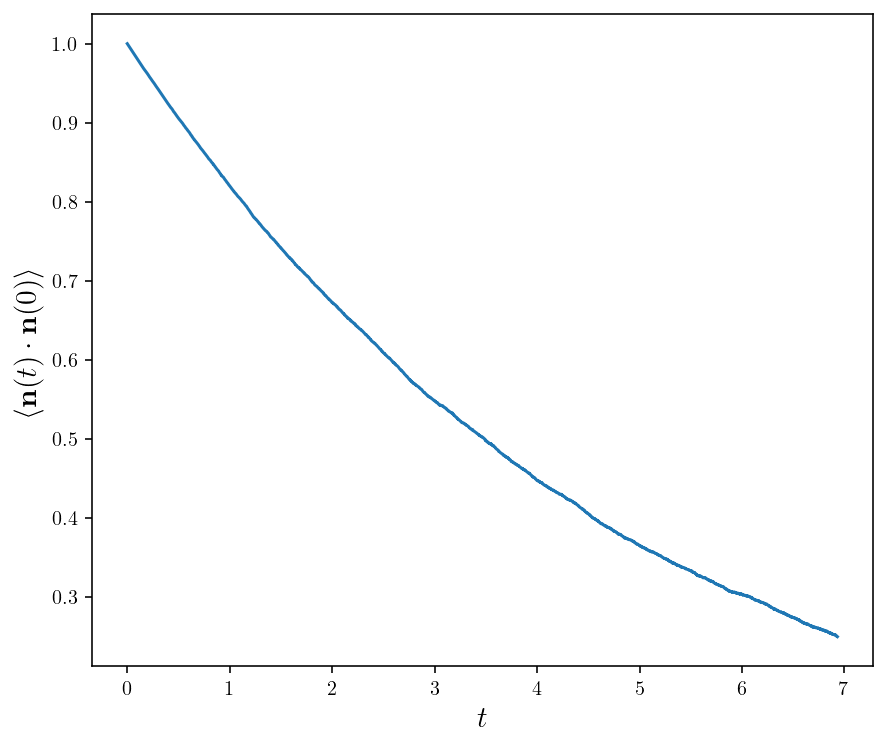

In [22]:
fig = plt.figure(figsize=(7,6))
plt.plot(tiempos, autocorr_t, label=r'%\lambda Y_{2}^{0}%')
#plt.plot(tiempos, np.exp(-(2*D*np.array(tiempos))), label='Free Diffusion')
plt.xlabel(r"$t$", fontsize=15)
plt.ylabel(r"$\langle \mathbf{n}(t)\cdot \mathbf{n}(0) \rangle$", fontsize=15)
plt.savefig("Autocorrelations4", dpi=250)

In [23]:
pwd

'/Users/adrianovaldesgomez/Documents/Adriano_Programming/AnalyticNumeric_theta_t_09012021'

In [24]:
np.savetxt("autocorr_matrix_t4.txt", autocorr_matrix)
np.savetxt("autocorr_pos_t4.txt", autocorr_t)

In [68]:
start_time = time.time()
D = 1*1e-1
dt = 1*np.log(2)*1e-3
N_ens = 10000
dist_ini = polo_n(N_ens,1.)
rs = dist_ini
thetas = [[0 for i in range(N_ens)]]
for i in range(7000):
    nuevas_pos = act_n(rs,D,dt)
    thetas.append(obt_thetas(nuevas_pos))
    rs = nuevas_pos
np.savetxt("Sim_Thetas_t_De-1dte-3_Ne10000_PMC7000.txt", thetas)
np.savetxt("Last_Config_rsDe-1dte-3_Ne10000_PMC7000.txt.txt", rs)
print("%s seconds" % (time.time() - start_time))

5665.465226888657 seconds


In [38]:
24000./3600

6.666666666666667

In [21]:
import numpy as np

In [442]:
#thetas = np.loadtxt("Sim_Thetas_t_03_extencion.txt")

In [22]:
from matplotlib import pyplot as plt

In [23]:
%matplotlib inline

In [69]:
type(thetas)

list

In [70]:
max(thetas[1])

0.06502542655789242

In [71]:
min(thetas[1])

1.7699167455796217e-06

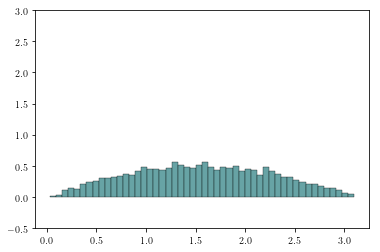

In [114]:
plt.hist(thetas[3500], bins=50, normed=True,color='cadetblue', alpha=0.95, label='Numeric Solution',#
             edgecolor='black', linewidth=.35);
plt.ylim(-.5,3);

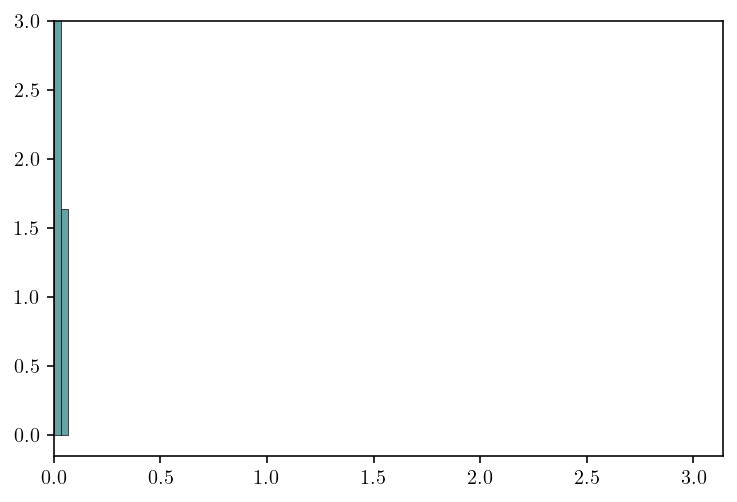

In [193]:
i = 1
plt.hist(thetas[i], bins=int(( np.array(thetas[i]).max() - np.array(thetas[i]).min() )*40), density=True,color='cadetblue', alpha=0.95, label='Numeric Solution',#
             edgecolor='black', linewidth=.35);
plt.ylim(-.15,3)
plt.xlim(0,np.pi);

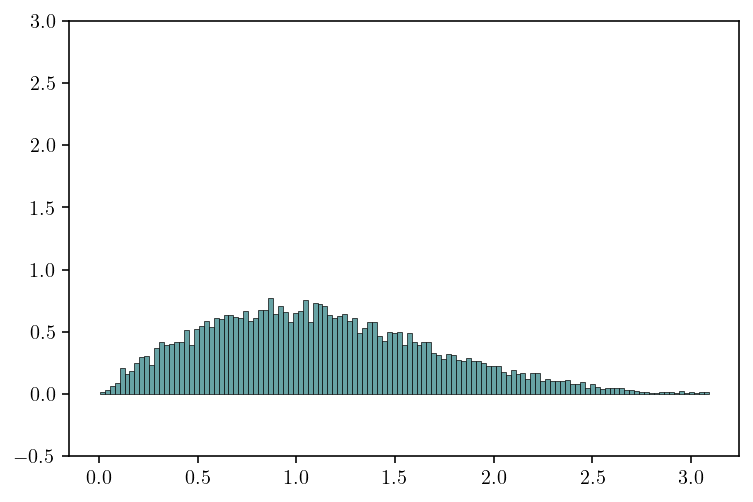

In [194]:
plt.hist(thetas[7000], bins=int(( np.array(thetas[7000][:]).max() - np.array(thetas[7000][:]).min() )*40), density=True,color='cadetblue', alpha=0.95, label='Numeric Solution',#
             edgecolor='black', linewidth=.35);
plt.ylim(-.5,3);

## Yuxtaposition plot

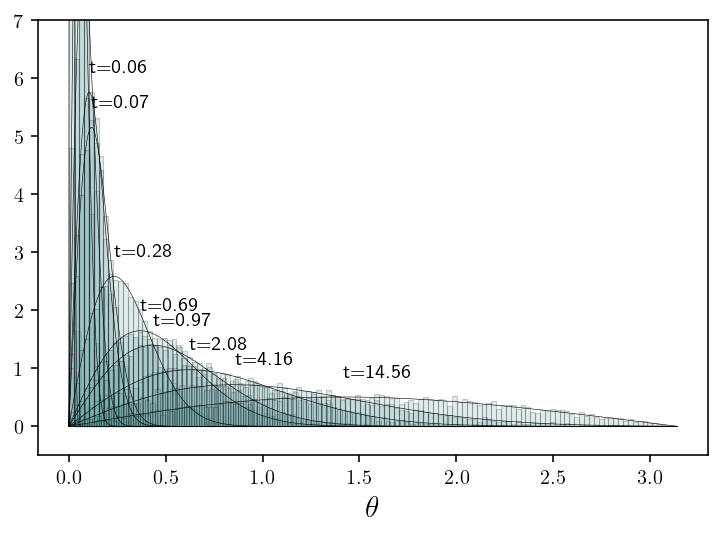

In [438]:
theta = np.linspace(0.0,np.pi,1000)
#fig = plt.figure(figsize=(8,8))
for i in [1,20,40,80,100,400,1000,1400,3000,6000,21000]:

    #plt.hist(thetas[i], bins=int(( np.array(thetas[i][:]).max() - np.array(thetas[i][:]).min() )*40),
    #         density=True,color='k', alpha=0.14, label='Numeric Solution', edgecolor='black', linewidth=.55);
    plt.hist(thetas[i], bins=int(( np.array(thetas[i][:]).max() - np.array(thetas[i][:]).min() )*40),
             density=True,color='cadetblue', alpha=0.2, label='Numeric Solution', edgecolor='black', linewidth=.55);
    plt.ylim(-.5,7)
    
    if ((distribucion_weighted(theta,i,1000,D,dt)[np.argmax(distribucion_weighted(theta,i,1000,D,dt))]+ 0.35) < 6.5):
        plt.text(theta[np.argmax(distribucion_weighted(theta,i,1000,D,dt))], 
                 distribucion_weighted(theta,i,1000,D,dt)[np.argmax(distribucion_weighted(theta,i,1000,D,dt))]+ 0.35,
                 't={0:.2f}'.format(i*dt))
    plt.plot(theta, distribucion_weighted(theta,i,1000,D,dt), color = 'k', alpha = .96,#
                     label=r"$P(\theta,t|0,0) = \sum P_{l}(\cos{\theta})\, \exp{[-l(l+1)D\,t]}$",linewidth=.3);
plt.xlabel(r'$\theta$', size=15);

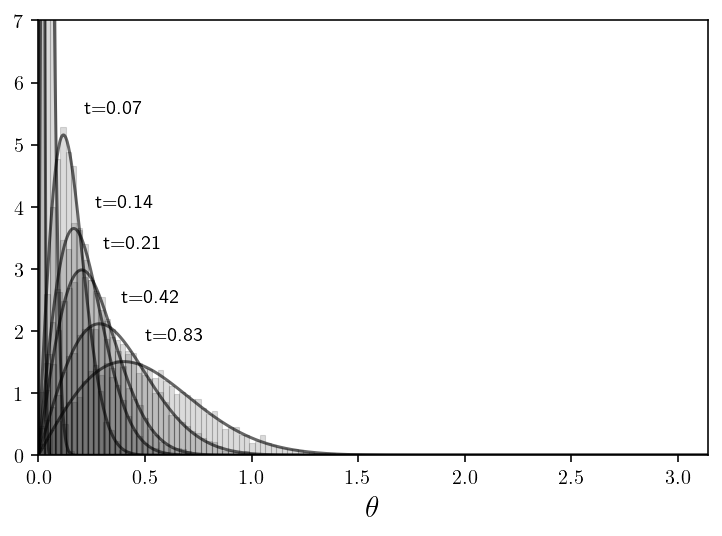

In [440]:
theta = np.linspace(0.0,np.pi,1000)

for i in [1,10,100,200,300,600,1200]:

    plt.hist(thetas[i], bins=int(( np.array(thetas[i][:]).max() - np.array(thetas[i][:]).min() )*40),
             density=True, color='k', alpha=0.14, label='Numeric Solution', edgecolor='black', linewidth=.55)
    #plt.hist(thetas[i], bins=int(( np.array(thetas[i][:]).max() - np.array(thetas[i][:]).min() )*40),
    #         density=True, color='cadetblue', alpha=0.4, label='Numeric Solution', edgecolor='black', linewidth=.55)
    plt.ylim(0,7)
    plt.plot(theta, distribucion_weighted(theta,i,1000,D,dt), color = 'k', alpha = .6,#
                 label=r"$P(\theta,t|0,0) = \sum P_{l}(\cos{\theta})\, \exp{[-l(l+1)D\,t/R]}$")
    plt.xlim(0, np.pi)
    if ((distribucion_weighted(theta,i,1000,D,dt)[np.argmax(distribucion_weighted(theta,i,1000,D,dt))]+ 0.35) < 6.5):
        plt.text(theta[np.argmax(distribucion_weighted(theta,i,1000,D,dt))]+.1, 
                 distribucion_weighted(theta,i,1000,D,dt)[np.argmax(distribucion_weighted(theta,i,1000,D,dt))]+ 0.35,
                 't={0:.2f}'.format(i*dt))
    #plt.title("t = {0:.4f} s".format(n*dt), fontsize=14)
    plt.xlabel(r"$\theta$", fontsize=15);
#plt.legend(fontsize=14.0);

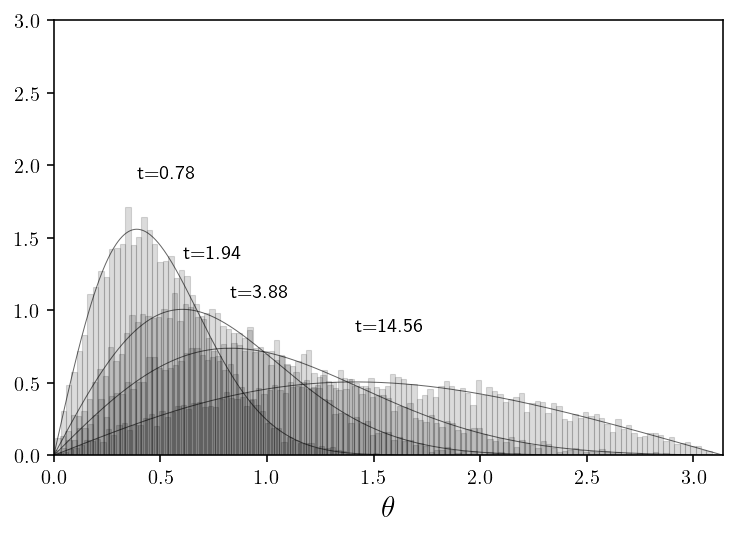

In [441]:
theta = np.linspace(0.0,np.pi,1000)

#for i in [2800,5600,1120,15600,21000]:
for i in [2800,5600,1120,21000]:

    plt.hist(thetas[i], bins=int(( np.array(thetas[i][:]).max() - np.array(thetas[i][:]).min() )*40),
             density=True,color='k', alpha=0.14, label='Numeric Solution', edgecolor='black', linewidth=.55)
    #plt.hist(thetas[i], bins=int(( np.array(thetas[i][:]).max() - np.array(thetas[i][:]).min() )*40),
    #         density=True,color='cadetblue', alpha=0.4, label='Numeric Solution', edgecolor='black', linewidth=.55)
    plt.ylim(0,3)
    plt.plot(theta, distribucion_weighted(theta,i,1000,D,dt), color = 'k', alpha = .6,#
                 label=r"$P(\theta,t|0,0) = \sum P_{l}(\cos{\theta})\, \exp{[-l(l+1)D\,t]}$",linewidth=.5)
    plt.text(theta[np.argmax(distribucion_weighted(theta,i,1000,D,dt))], 
             distribucion_weighted(theta,i,1000,D,dt)[np.argmax(distribucion_weighted(theta,i,1000,D,dt))]+ 0.35,
             't={0:.2f}'.format(i*dt))
    plt.xlim(0, np.pi)
    #plt.legend(fontsize=14.0);
    #plt.title("t = {0:.4f} s".format(n*dt), fontsize=14)
    plt.xlabel(r"$\theta$", fontsize=15)

In [278]:
import seaborn as sns

In [298]:
sns.color_palette("Greys", 20)

[(0.9778546712802768, 0.9778546712802768, 0.9778546712802768),
 (0.9557093425605536, 0.9557093425605536, 0.9557093425605536),
 (0.9295040369088812, 0.9295040369088812, 0.9295040369088812),
 (0.8955478662053056, 0.8955478662053056, 0.8955478662053056),
 (0.8615916955017301, 0.8615916955017301, 0.8615916955017301),
 (0.819115724721261, 0.819115724721261, 0.819115724721261),
 (0.7777777777777778, 0.7777777777777778, 0.7777777777777778),
 (0.7345790080738178, 0.7345790080738178, 0.7345790080738178),
 (0.6770011534025375, 0.6770011534025375, 0.6770011534025375),
 (0.6194232987312572, 0.6194232987312572, 0.6194232987312572),
 (0.560246059207997, 0.560246059207997, 0.560246059207997),
 (0.5085736255286428, 0.5085736255286428, 0.5085736255286428),
 (0.45690119184928873, 0.45690119184928873, 0.45690119184928873),
 (0.40784313725490196, 0.40784313725490196, 0.40784313725490196),
 (0.35912341407151094, 0.35912341407151094, 0.35912341407151094),
 (0.30080738177623995, 0.30080738177623995, 0.30080738177623995),
 (0.23437139561707038, 0.23437139561707038, 0.23437139561707038),
 (0.1679354094579008, 0.1679354094579008, 0.1679354094579008),
 (0.10925028835063438, 0.10925028835063438, 0.10925028835063438),
 (0.05462514417531719, 0.05462514417531719, 0.05462514417531719)]

In [300]:
sns.light_palette("seagreen", n_colors=20)

[(0.921460863132993, 0.9512120106378944, 0.9302557793948234),
 (0.8836808898721569, 0.9305081611144093, 0.9002242852203699),
 (0.8459009166113207, 0.9098043115909241, 0.8701927910459164),
 (0.8052147915611895, 0.8875078582579402, 0.8378511819349664),
 (0.7674348183003533, 0.8668040087344551, 0.8078196877605129),
 (0.7267486932502221, 0.844507555401471, 0.775478078649563),
 (0.6889687199893858, 0.8238037058779859, 0.7454465844751095),
 (0.6482825949392546, 0.801507252545002, 0.7131049753641595),
 (0.6105026216784184, 0.7808034030215169, 0.683073481189706),
 (0.5698164966282872, 0.7585069496885328, 0.650731872078756),
 (0.532036523367451, 0.7378031001650478, 0.6207003779043025),
 (0.4913503983173198, 0.7155066468320638, 0.5883587687933527),
 (0.4535704250564836, 0.6948027973085786, 0.5583272746188992),
 (0.41288430000635234, 0.6725063439755947, 0.5259856655079492),
 (0.3751043267455161, 0.6518024944521095, 0.4959541713334957),
 (0.33441820169538494, 0.6295060411191256, 0.4636125622225458),
 (0.2966382284345487, 0.6088021915956405, 0.43358106804809227),
 (0.25595210338441743, 0.5865057382626564, 0.4012394589371423),
 (0.21817213012358128, 0.5658018887391714, 0.3712079647626888),
 (0.1803921568627451, 0.5450980392156862, 0.3411764705882353)]

In [286]:
mi_paleta = sns.color_palette("Greys", 4)

In [283]:
sns.light_palette("seagreen", as_cmap=True)

In [296]:
mi_paleta = sns.light_palette("seagreen", n_colors=4)

In [304]:
mi_paleta = sns.color_palette("husl", n_colors=4)

In [323]:
mi_paleta = sns.color_palette("Spectral", n_colors=4)

In [324]:
sns.color_palette("Spectral", n_colors=40)

[(0.6703575547866205, 0.0602076124567474, 0.27081891580161477),
 (0.7211072664359862, 0.11649365628604381, 0.28281430219146486),
 (0.7718569780853518, 0.17277970011534027, 0.2948096885813149),
 (0.8226066897347175, 0.22906574394463664, 0.30680507497116494),
 (0.8615148019992311, 0.28289119569396387, 0.2996539792387543),
 (0.8901191849288735, 0.3262591311034217, 0.28858131487889277),
 (0.9187235678585159, 0.3696270665128797, 0.2775086505190312),
 (0.9473279507881585, 0.4129950019223375, 0.2664359861591696),
 (0.9637831603229527, 0.47743175701653207, 0.28581314878892733),
 (0.972087658592849, 0.5374086889657823, 0.3134948096885813),
 (0.9803921568627452, 0.5973856209150326, 0.34117647058823525),
 (0.9886966551326413, 0.6573625528642827, 0.36885813148788915),
 (0.9928489042675894, 0.716955017301038, 0.40945790080738165),
 (0.9937716262975779, 0.7630911188004613, 0.44821222606689726),
 (0.9946943483275663, 0.8092272202998846, 0.48696655132641287),
 (0.9956170703575548, 0.855363321799308, 0.5257208765859285),
 (0.9966935793925413, 0.8975009611687812, 0.5770857362552863),
 (0.9976163014225298, 0.9261053440984237, 0.6250672818146866),
 (0.9985390234525182, 0.9547097270280661, 0.6730488273740869),
 (0.9994617454825068, 0.9833141099577085, 0.7210303729334872),
 (0.9865436370626682, 0.9946174548250672, 0.7280276816608997),
 (0.9634755863129566, 0.9853902345251826, 0.6920415224913495),
 (0.940407535563245, 0.976163014225298, 0.6560553633217994),
 (0.9173394848135333, 0.9669357939254134, 0.6200692041522493),
 (0.874740484429066, 0.9497116493656287, 0.6016147635524798),
 (0.8202998846597465, 0.9275663206459055, 0.6126874279123413),
 (0.765859284890427, 0.9054209919261824, 0.623760092272203),
 (0.7114186851211075, 0.8832756632064592, 0.6348327566320646),
 (0.6440599769319495, 0.8562860438292965, 0.643521722414456),
 (0.5803921568627453, 0.8313725490196079, 0.6444444444444445),
 (0.516724336793541, 0.8064590542099193, 0.6453671664744329),
 (0.4530565167243369, 0.7815455594002307, 0.6462898885044214),
 (0.38400615148019995, 0.7429450211457131, 0.6544405997693196),
 (0.33602460592079997, 0.6894271434063823, 0.6765859284890426),
 (0.2880430603613995, 0.6359092656670511, 0.6987312572087659),
 (0.24006151480199925, 0.58239138792772, 0.7208765859284891),
 (0.20622837370242214, 0.5201845444059977, 0.7349480968858132),
 (0.24682814302191466, 0.4675893886966551, 0.7100346020761246),
 (0.2874279123414072, 0.4149942329873126, 0.6851211072664359),
 (0.3280276816608997, 0.36239907727797005, 0.6602076124567474)]

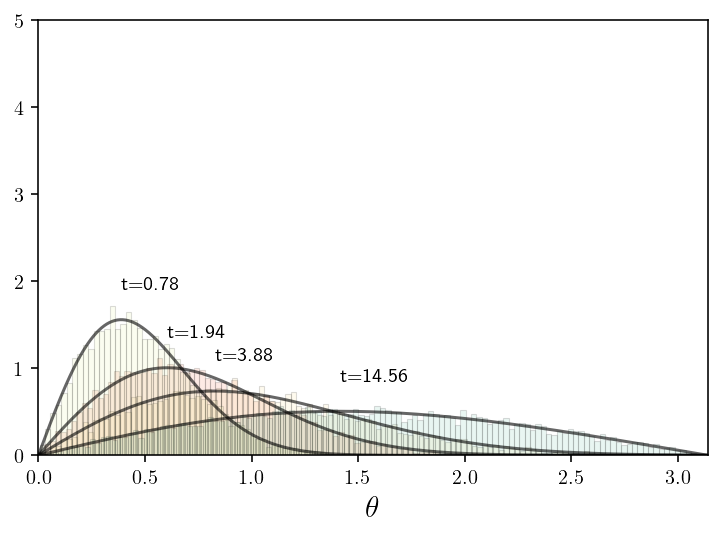

In [325]:
theta = np.linspace(0.0,np.pi,1000)

#for i in [2800,5600,1120,15600,21000]:

snaps = [2800,5600,1120,21000]

for i in snaps:

    plt.hist(thetas[i], bins=int(( np.array(thetas[i][:]).max() - np.array(thetas[i][:]).min() )*40),
             density=True,color=mi_paleta[snaps.index(i)], alpha=0.14, label='Numeric Solution', 
             edgecolor='black', linewidth=.55)
    #plt.hist(thetas[i], bins=int(( np.array(thetas[i][:]).max() - np.array(thetas[i][:]).min() )*40),
    #         density=True,color='cadetblue', alpha=0.4, label='Numeric Solution', edgecolor='black', linewidth=.55)
    plt.ylim(0,5)
    plt.plot(theta, distribucion_weighted(theta,i,1000,D), color = 'k', alpha = .6,#
                 label=r"$P(\theta,t|0,0) = \sum P_{l}(\cos{\theta})\, \exp{[-l(l+1)D\,t]}$")
    plt.text(theta[np.argmax(distribucion_weighted(theta,i,1000,D))], 
             distribucion_weighted(theta,i,1000,D)[np.argmax(distribucion_weighted(theta,i,1000,D))]+ 0.35,
             't={0:.2f}'.format(i*dt))
    plt.xlim(0, np.pi)
    #plt.legend(fontsize=14.0);
    #plt.title("t = {0:.4f} s".format(n*dt), fontsize=14)
    plt.xlabel(r"$\theta$", fontsize=15)

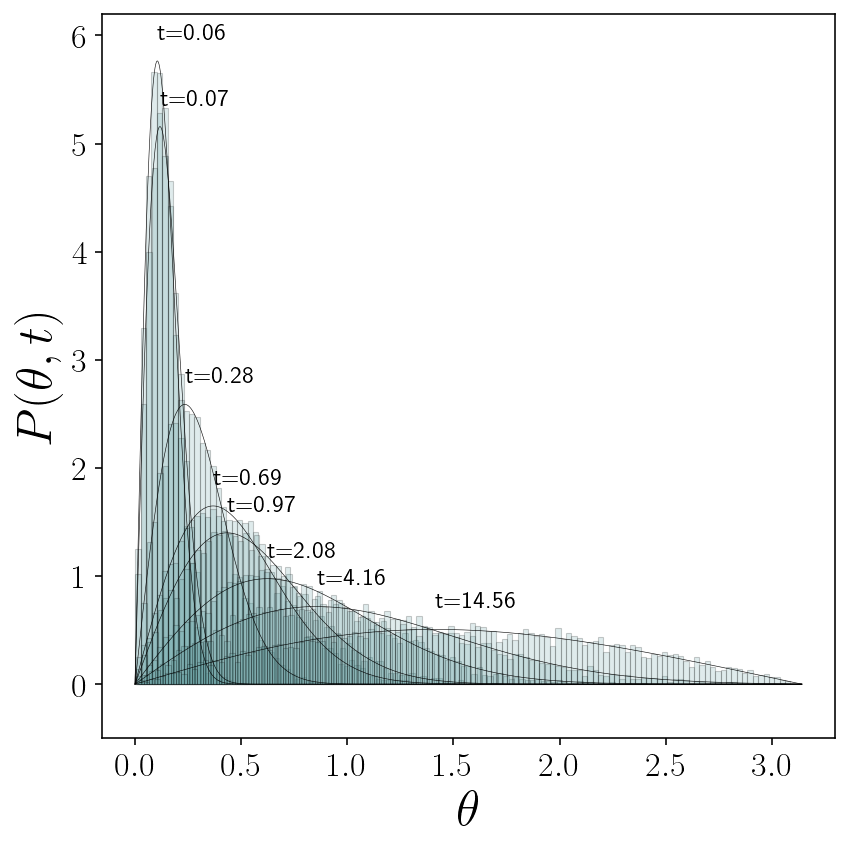

In [340]:
theta = np.linspace(0.0,np.pi,1000)
fig = plt.figure(figsize=(6,6))
for i in [80,100,400,1000,1400,3000,6000,21000]:

    #plt.hist(thetas[i], bins=int(( np.array(thetas[i][:]).max() - np.array(thetas[i][:]).min() )*40),
    #         density=True,color='k', alpha=0.14, label='Numeric Solution', edgecolor='black', linewidth=.55);
    plt.hist(thetas[i], bins=int(( np.array(thetas[i][:]).max() - np.array(thetas[i][:]).min() )*40),
             density=True,color='cadetblue', alpha=0.2, label='Numeric Solution', edgecolor='black', linewidth=.55);
    plt.ylim(-.5,6.2)
    
    if ((distribucion_weighted(theta,i,1000,D)[np.argmax(distribucion_weighted(theta,i,1000,D))]+ 0.35) < 6.5):
        plt.text(theta[np.argmax(distribucion_weighted(theta,i,1000,D))], 
                 distribucion_weighted(theta,i,1000,D)[np.argmax(distribucion_weighted(theta,i,1000,D))]+ 0.2,
                 't={0:.2f}'.format(i*dt), fontsize=12)
    plt.plot(theta, distribucion_weighted(theta,i,1000,D), color = 'k', alpha = .96,#
                     label=r"$P(\theta,t|0,0) = \sum P_{l}(\cos{\theta})\, \exp{[-l(l+1)D\,t]}$",linewidth=.3);
plt.xlabel(r'$\theta$', size=25)
plt.ylabel(r'$P(\theta,t)$', size=25)
plt.xticks(size=17)
plt.yticks(size=17)
plt.tight_layout();

In [375]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

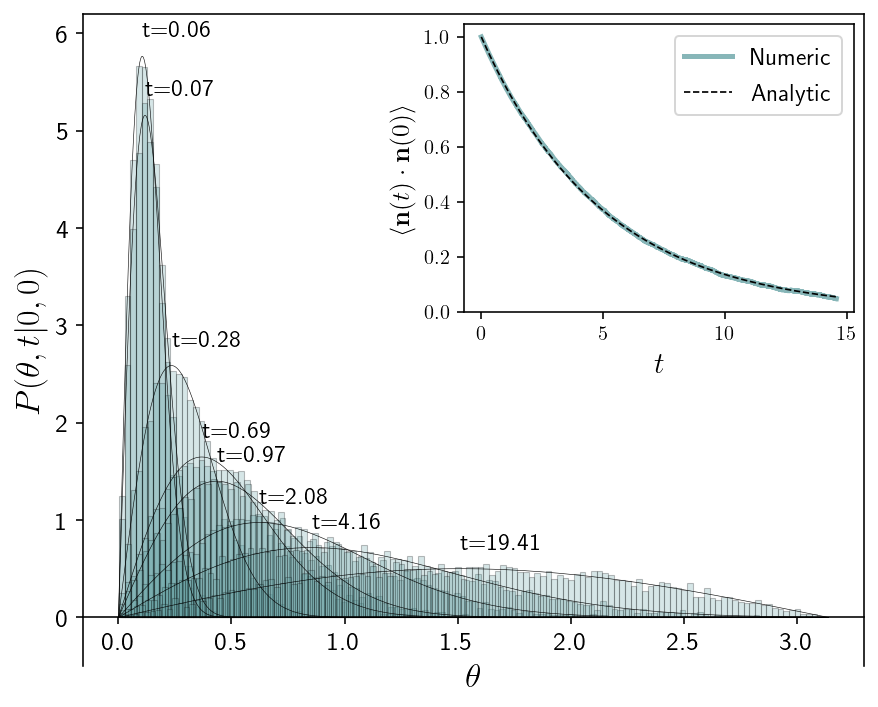

In [444]:
theta = np.linspace(0.0,np.pi,1000)


fig, ax = plt.subplots(figsize=(7,6))

ax.spines['bottom'].set_position('zero')
for i in [80,100,400,1000,1400,3000,6000,28000]:

    #plt.hist(thetas[i], bins=int(( np.array(thetas[i][:]).max() - np.array(thetas[i][:]).min() )*40),
    #         density=True,color='k', alpha=0.14, label='Numeric Solution', edgecolor='black', linewidth=.55);
    ax.hist(thetas[i], bins=int(( np.array(thetas[i][:]).max() - np.array(thetas[i][:]).min() )*40),
             density=True,color='cadetblue', alpha=0.25, label='Numeric Solution', edgecolor='black', linewidth=.55);
    ax.set_ylim(-.5,6.2)
    
    if ((distribucion_weighted(theta,i,1000,D,dt)[np.argmax(distribucion_weighted(theta,i,1000,D,dt))]+ 0.35) < 6.5):
        ax.text(theta[np.argmax(distribucion_weighted(theta,i,1000,D,dt))], 
                 distribucion_weighted(theta,i,1000,D,dt)[np.argmax(distribucion_weighted(theta,i,1000,D,dt))]+ 0.2,
                 't={0:.2f}'.format(i*dt), fontsize=12)
    ax.plot(theta, distribucion_weighted(theta,i,1000,D,dt), color = 'k', alpha = .96,#
                     label=r"$P(\theta,t|0,0) = \sum P_{l}(\cos{\theta})\, \exp{[-l(l+1)D\,t]}$",linewidth=.3);
ax.set_xlabel(r'$\theta$', size=17)
ax.set_ylabel(r'$P(\theta,t|0,0)$', size=17)

ax.set_xticks([i*.5 for i in range(7) ])
ax.set_yticks([i for i in range(7)])

ax.set_xticklabels([str(i*.5) for i in range(7) ], fontsize=13)
ax.set_yticklabels([str(i) for i in range(7)] , fontsize=13)

ins = inset_axes(ax, 
                    width="50%", # width = 30% of parent_bbox
                    height=2.0, # height : 1 inch
                    loc=1)
ins.plot(tiempos, mean_cos_thetas_t, label= 'Numeric', alpha=.75, linewidth=2.5, color = 'cadetblue')
#plt.scatter(tiempos, mean_cos_thetas_t, label= 'Numeric', marker='o', s=5, alpha=.05)
ins.plot(tiempos, np.exp(-(2*D*np.array(tiempos))), label='Analytic', color='k', linewidth=0.85, linestyle='--')
ins.legend(fontsize=12)
ins.set_xlabel(r"$t$", fontsize=15)
ins.set_ylabel(r"$\langle \mathbf{n}(t)\cdot \mathbf{n}(0) \rangle$", fontsize=13);
#ax.set_tight_layout();
#fig.savefig('Figure_06-1.png', dpi=250)

In [533]:
tiempos = []
suma = 0.
for i in range(len(thetas)):
    suma =+ i*dt
    tiempos.append(suma)

In [537]:
len(tiempos)

42001

In [669]:
def plot_free_diff(thetas, l_steps, title, dpi, save=False, show=True):
    """This function plots """
    theta = np.linspace(0.0,np.pi,1000)
    tiempos = []
    suma = 0.
    for i in range(len(thetas)):
        suma =+ i*dt
        tiempos.append(suma)
        
    mean_cos_thetas_t =[]
    for ensamble in thetas:
        ensamble = np.array(ensamble)
        cos_ens = np.cos(ensamble)
        mean_cos_thetas_t.append(np.mean(cos_ens))

    fig, ax = plt.subplots(figsize=(7,6))

    ax.spines['bottom'].set_position('zero')
    for i in l_steps:

        #plt.hist(thetas[i], bins=int(( np.array(thetas[i][:]).max() - np.array(thetas[i][:]).min() )*40),
        #         density=True,color='k', alpha=0.14, label='Numeric Solution', edgecolor='black', linewidth=.55);
        ax.hist(thetas[i], bins=int(( np.array(thetas[i][:]).max() - np.array(thetas[i][:]).min() )*40),
                 density=True,color='cadetblue', alpha=0.25, label='Numeric Solution', edgecolor='black', linewidth=.55);
        ax.set_ylim(-.5,6.2)

        if ((distribucion_weighted(theta,i,1000,D,dt)[np.argmax(distribucion_weighted(theta,i,1000,D,dt))]+ 0.35) < 6.5):
            ax.text(theta[np.argmax(distribucion_weighted(theta,i,1000,D,dt))], 
                     distribucion_weighted(theta,i,1000,D,dt)[np.argmax(distribucion_weighted(theta,i,1000,D,dt))]+ 0.2,
                     't={0:.2f}'.format(i*dt), fontsize=12)
        ax.plot(theta, distribucion_weighted(theta,i,1000,D,dt), color = 'k', alpha = .96,#
                         label=r"$P(\theta,t|0,0) = \sum P_{l}(\cos{\theta})\, \exp{[-l(l+1)D\,t]}$",linewidth=.3);
    ax.set_xlabel(r'$\theta$', size=19)
    ax.set_ylabel(r'$\overline{P}(\theta,t|0,0)$', size=19)

    ax.set_xticks([i*.5 for i in range(7) ])
    ax.set_yticks([i for i in range(7)])

    ax.set_xticklabels([str(i*.5) for i in range(7) ], fontsize=13)
    ax.set_yticklabels([str(i) for i in range(7)] , fontsize=13)

    ins = inset_axes(ax, 
                        width="50%", # width = 30% of parent_bbox
                        height=2.0, # height : 1 inch
                        loc=1)
    #print(len(tiempos))
    ins.plot(tiempos, mean_cos_thetas_t, label= 'Numeric', alpha=.75, linewidth=2.5,
             color = 'cadetblue', linestyle=':')
    #plt.scatter(tiempos, mean_cos_thetas_t, label= 'Numeric', marker='o', s=5, alpha=.05)
    ins.plot(tiempos, np.exp(-(2*D*np.array(tiempos))), label='Analytic', color='k', linewidth=0.85, linestyle='-')
    ins.legend(fontsize=12)
    ins.set_xlabel(r"$t$", fontsize=15)
    ins.set_ylabel(r"$\langle \mathbf{n}(t)\cdot \mathbf{n}(0) \rangle$", fontsize=14);
    #ax.set_tight_layout();
    if save:
        fig.savefig(title, dpi=dpi)
    if show:
        plt.show()

In [670]:
l_s = [80,100,400,1000,1400,3000,6000,42000]

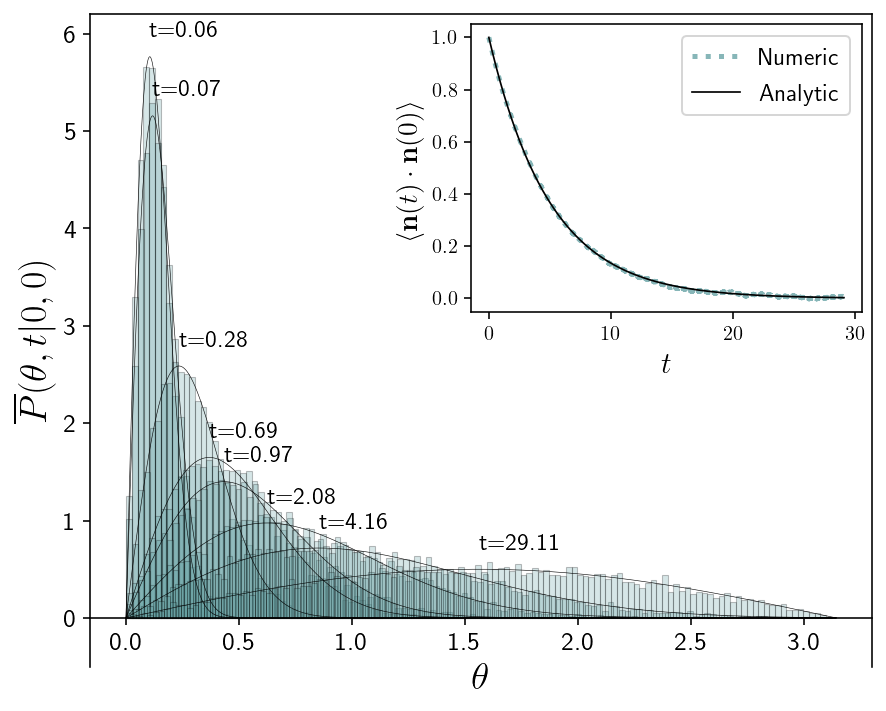

In [671]:
plot_free_diff(thetas, l_s, 'Figure_06-1.png', 250, True)

In [545]:
len(mean_cos_thetas_t)

21001

In [672]:
pwd

'/Users/adrianovaldesgomez/Documents/Adriano_Programming/AnalyticNumeric_theta_t_09012021'

In [241]:
thetas[np.argmax(distribucion_weighted(theta,2800,1000,D))],distribucion_weighted(theta,i,1000,D)[np.argmax(distribucion_weighted(theta,i,1000,D))]+ 0.1

([0.14709818576444572,
  0.16885362785742575,
  0.3489866824148399,
  0.1455739617185991,
  0.15708018909051014,
  0.1511016908903779,
  0.1363067502116515,
  0.11922275184848352,
  0.08000655733419197,
  0.3161993269986188,
  0.39585528430761563,
  0.3220130218624922,
  0.045362751859423615,
  0.0653313857621867,
  0.3940796139077433,
  0.2262064717331197,
  0.1209994901978216,
  0.2935105368259638,
  0.1234031460526429,
  0.2548987069013817,
  0.10325997451986495,
  0.1846139229166712,
  0.6217292277628721,
  0.2880177017134405,
  0.2504100441761269,
  0.1817460231593735,
  0.22462310291790316,
  0.051829102476983954,
  0.11592908469756612,
  0.12947188985171293,
  0.24151534907138925,
  0.43339261138524987,
  0.39816449464250564,
  0.16019430217408553,
  0.1272224190965101,
  0.2955892276214129,
  0.11955342078703278,
  0.15844330200118784,
  0.18568916619970716,
  0.3098446387831916,
  0.05176444630159066,
  0.009776018550729494,
  0.4418120704823121,
  0.18492731742826377,
  0.159

In [223]:
l_test = [0,9,2,3]

In [224]:
max(l_test)

9

In [225]:
l_test.index(max(l_test))

1

In [226]:
l_test[l_test.index(max(l_test))]

9

In [233]:
an_array = np.array([[1, 1, 3], [1, 2, 1]])

max_index_col = np.argmax(an_array, axis=0)


print(max_index_col)

max_index_row = np.argmax(an_array, axis=1)


print(max_index_row)

[0 1 0]
[2 1]


In [235]:
np.argmax(distribucion_weighted(theta,2800,1000,D))

192

In [236]:
distribucion_weighted(theta,2800,1000,D)[np.argmax(distribucion_weighted(theta,2800,1000,D))]

1.0070447762299448

# Extension

In [450]:
start_time = time.time()
for i in range(7000):
    nuevas_pos = act_n(rs,D,dt)
    thetas.append(obt_thetas(nuevas_pos))
    rs = nuevas_pos
np.savetxt("Sim_Thetas_t_De-1dte-3_Ne10000_PMC7000_06.txt", thetas)
np.savetxt("Last_Config_rsDe-1dte-3_Ne10000_PMC7000_06.txt", rs)
print("%s seconds" % (time.time() - start_time))

6450.271012067795 seconds


In [197]:
len(thetas)

21001

## Check up maximumconfiguration for a saved file

In [16]:
thetas_s = np.loadtxt("AnalyticNumeric_theta_t_12102019/Sim_Thetas_t_01.txt")

In [18]:
%mkdir AnalyticNumeric_theta_t_09012021

In [19]:
cd AnalyticNumeric_theta_t_09012021/

/Users/adrianovaldesgomez/Documents/Adriano_Programming/AnalyticNumeric_theta_t_09012021


In [21]:
len(thetas_s[0])

6000

In [46]:
thetas_s.shape

(4501, 6000)

In [48]:
thetas_s[10,:].min()

0.004145642795451231

In [49]:
int(( thetas_s[10,:].max() - thetas_s[10,:].min() )*80)

41

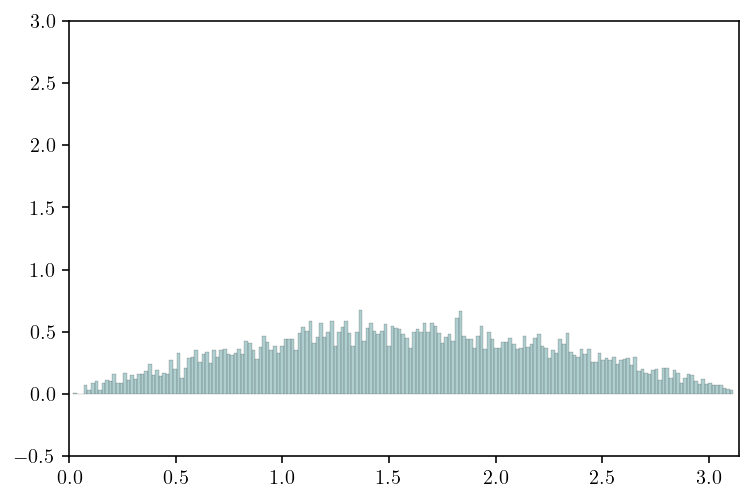

In [65]:
i = 4500
plt.hist(thetas_s[i], bins= int(( thetas_s[i,:].max() - thetas_s[i,:].min() )*60), density=True,color='cadetblue', alpha=0.5, label='Numeric Solution',#
             edgecolor='black', linewidth=.15);
plt.ylim(-.5,3)
plt.xlim(0,np.pi);

# Plots

In [115]:
D = 1*1e-1
dt = 1*np.log(2)*1e-2
theta = np.linspace(0.0,np.pi,1000)

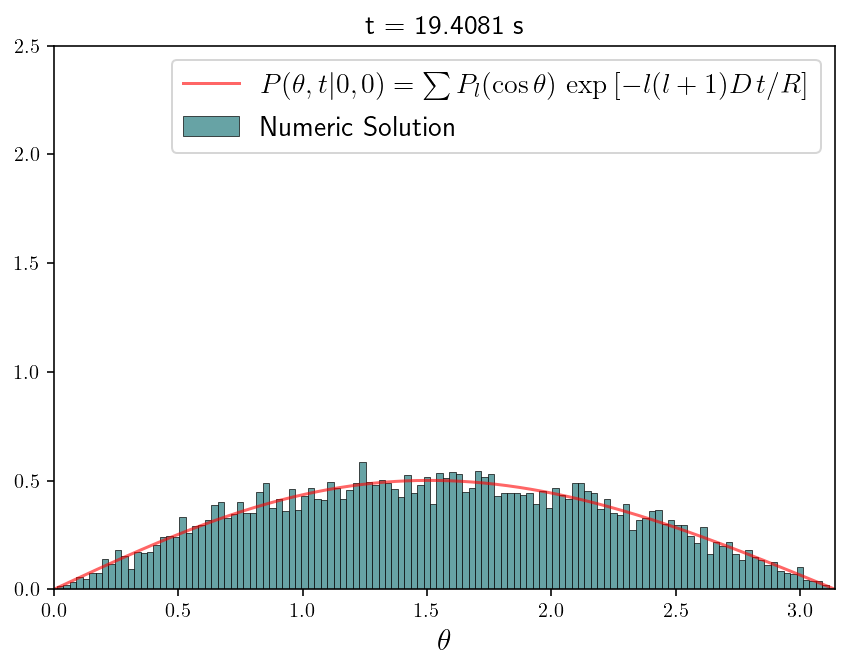

In [419]:
fig = plt.figure(figsize=(7,5))
plt.hist(thetas[-1], bins=120, color='cadetblue', alpha=0.95, label='Numeric Solution',#
         edgecolor='black', linewidth=.35, density=True);
plt.plot(theta, distribucion_weighted(theta,28000,1000,D), color = 'r', alpha = .6,#
         label=r"$P(\theta,t|0,0) = \sum P_{l}(\cos{\theta})\, \exp{[-l(l+1)D\,t/R]}$")
plt.ylim(0,2.5);
plt.xlim(0, np.pi);
plt.legend(fontsize=14.0);
plt.title("t = {0:.4f} s".format(28000*dt), fontsize=14)
plt.xlabel(r"$\theta$", fontsize=15);
#fig.savefig('Sim_free_diff_analytic_vs_Numeric_Img{}.png'.format(nombre(n)), dpi=200)

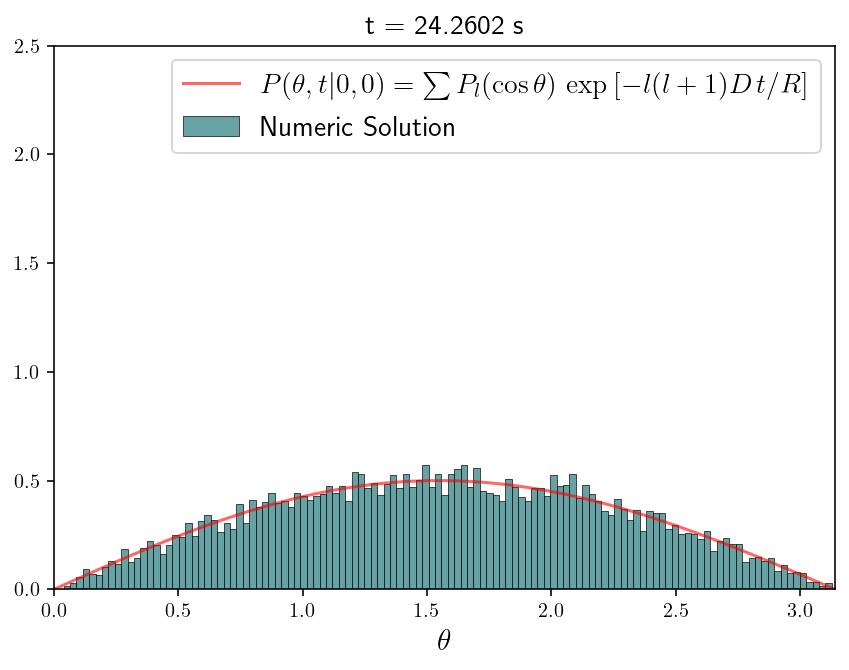

In [421]:
fig = plt.figure(figsize=(7,5))
plt.hist(thetas[-1], bins=120, color='cadetblue', alpha=0.95, label='Numeric Solution',#
         edgecolor='black', linewidth=.35, density=True);
plt.plot(theta, distribucion_weighted(theta,35000,1000,D), color = 'r', alpha = .6,#
         label=r"$P(\theta,t|0,0) = \sum P_{l}(\cos{\theta})\, \exp{[-l(l+1)D\,t/R]}$")
plt.ylim(0,2.5);
plt.xlim(0, np.pi);
plt.legend(fontsize=14.0);
plt.title("t = {0:.4f} s".format(35000*dt), fontsize=14)
plt.xlabel(r"$\theta$", fontsize=15);
#fig.savefig('Sim_free_diff_analytic_vs_Numeric_Img{}.png'.format(nombre(n)), dpi=200)

In [154]:
def Num_Analytic(n):
    fig = plt.figure(figsize=(7,5))
    plt.hist(thetas[n], bins=120, color='cadetblue', alpha=0.95, label='Numeric Solution',#
             edgecolor='black', linewidth=.35, density=True);
    plt.plot(theta, distribucion_weighted(theta,n,1000,D), color = 'r', alpha = .6,#
             label=r"$P(\theta,t|0,0) = \sum P_{l}(\cos{\theta})\, \exp{[-l(l+1)D\,t/R]}$")
    plt.ylim(0,2.5);
    plt.xlim(0, np.pi);
    plt.legend(fontsize=14.0);
    plt.title("t = {0:.4f} s".format(n*dt), fontsize=14)
    plt.xlabel(r"$\theta$", fontsize=15)
    fig.savefig('Sim_free_diff_analytic_vs_Numeric_Img{}.png'.format(nombre(n)), dpi=200)

In [153]:
plt.hist?

In [117]:
len(thetas)

4501

In [34]:
%pwd

'/Users/adrianovaldesgomez/Documents/Adriano_Programming/AnalyticNumeric_theta_t'

In [35]:
%cd ..

/Users/adrianovaldesgomez/Documents/Adriano_Programming


In [36]:
%mkdir Analytic_vs_Numeric_Snapshots_Paper

In [37]:
%cd Analytic_vs_Numeric_Snapshots_Paper/

/Users/adrianovaldesgomez/Documents/Adriano_Programming/Analytic_vs_Numeric_Snapshots_Paper


In [118]:
original_thetas = thetas

In [119]:
thetas = np.array(thetas)

In [138]:
%config InlineBackend.figure_format ='retina'

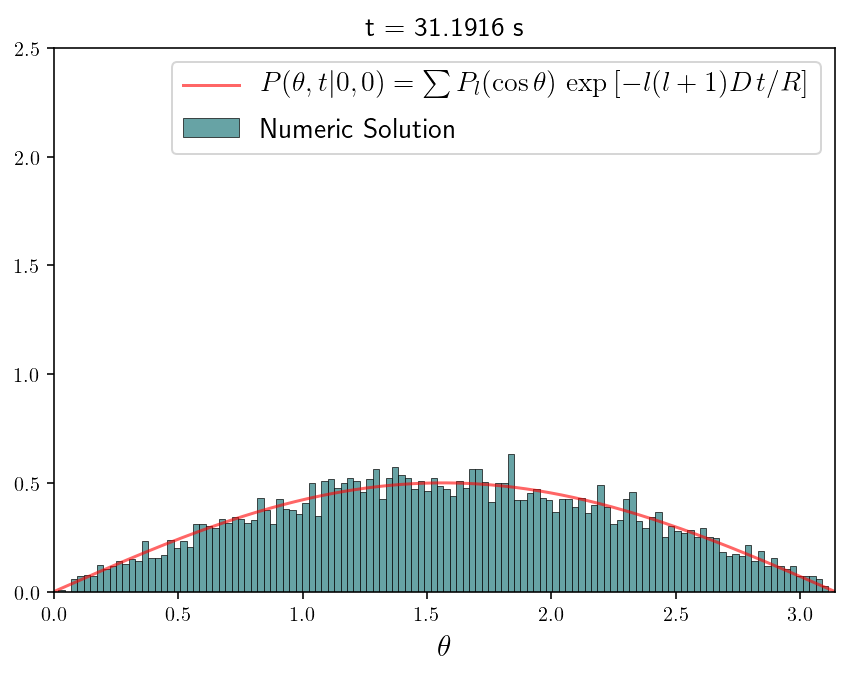

In [155]:
Num_Analytic(thetas.shape[0]-1)

In [186]:
%pwd

'/Users/adrianovaldesgomez/Documents/Adriano_Programming/AnalyticNumeric_theta_t_12102019'

In [123]:
tick_labels

['0.0',
 '0.5235987755982988',
 '1.0471975511965976',
 '1.5707963267948966',
 '2.0943951023931953',
 '2.6179938779914944',
 '3.141592653589793']

In [121]:
import fractions

In [126]:
str(fractions.Fraction(np.pi,3))

TypeError: both arguments should be Rational instances

In [187]:
lista1 = [1,3,0]
lista2 = [-1,2,7]

In [189]:
la1 = np.array(lista1)
la2 = np.array(lista2)

In [190]:
la1*la2

array([-1,  6,  0])

## Other approaches for comparision

In [453]:
mean_thetas_t =[]
for ensamble in thetas:
    mean_thetas_t.append(np.mean(ensamble))

In [454]:
mean_true_theta_square_t = []
thetas_array = np.array(thetas)
for sub_array in thetas_array:
    mean_true_theta_square_t.append(np.mean(sub_array*sub_array))

In [455]:
mean_thetas_square_t = []
for ensamble in thetas:
    mean_thetas_square_t.append(np.var(ensamble))

In [342]:
tiempos = []
suma = 0.
for i in range(thetas.shape[0]):
    suma =+ i*dt
    tiempos.append(suma)

AttributeError: 'list' object has no attribute 'shape'

In [456]:
tiempos = []
suma = 0.
for i in range(len(thetas)):
    suma =+ i*dt
    tiempos.append(suma)

In [159]:
tiempos2 = []
suma = 0.
for i in range(len(mean_thetas_t)):
    suma =+ i*dt
    tiempos2.append(suma)

In [471]:
tiempos2 = []
suma = 0.
for i in range(len(theta_numint_mean_t)):
    suma =+ i*dt
    tiempos2.append(suma)

In [477]:
len(theta_numint_mean_t)

4200

In [126]:
!pwd

/Users/adrianovaldesgomez/Documents/Adriano_Programming/AnalyticNumeric_theta_t_12102019


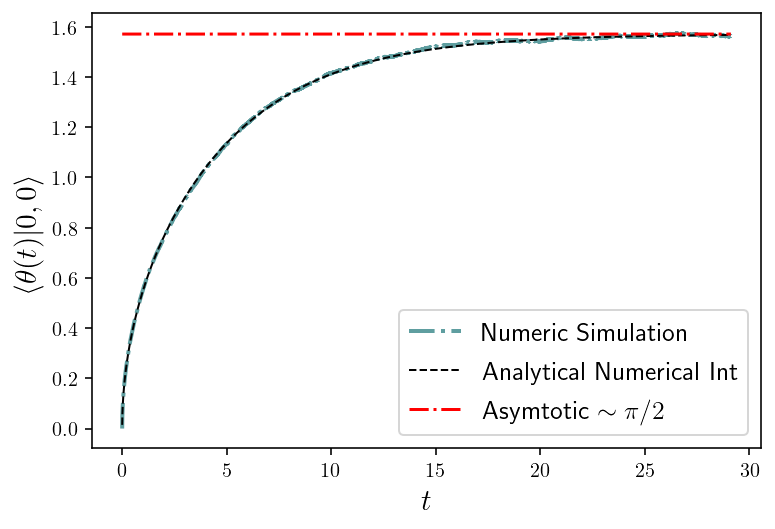

In [558]:
plt.plot(tiempos, mean_thetas_t, label= 'Numeric Simulation', color='cadetblue',
         alpha=1.0, linestyle='-.',linewidth=2)
#plt.plot(tiempos, np.arccos(np.exp(-(2*D*np.array(tiempos)))), label='Analytic')
plt.plot(tiempos2[:], theta_numint_mean_t[:], label='Analytical Numerical Int', linewidth=1,
         linestyle='--', color='k', alpha=1.0)
plt.plot(tiempos2[:], np.pi/2*np.ones_like(tiempos2[:]), label=r'Asymtotic $\sim \pi/2$', color='r', linestyle='-.')
plt.legend(fontsize=13)
plt.xlabel(r"$t$", fontsize=15)
plt.ylabel(r"$\langle \theta(t)|0,0 \rangle$", fontsize=15);
plt.savefig("Mean_of_theta_t_Num_Ana.png", dpi=200)


In [174]:
var = (np.pi**2 - 4)/2. - np.pi**2/4

In [175]:
var

0.4674011002723395

In [473]:
D

0.1

## Expresión tiempos cortos

In [162]:
s2 = 4*D*np.array(tiempos) 
s5 = 4*D*np.array(tiempos) - (4/3.)*D*np.array(tiempos)**2
s6 = 4*D*np.array(tiempos) - (4/3.)*D*np.array(tiempos)**2 - (8/45.)*D*np.array(tiempos)**3
s7 = 4*D*np.array(tiempos) - 3.2*D*np.array(tiempos)

In [163]:
s3 = 1.6/2*D*np.array(tiempos)

## Expresión tiempos largos

In [467]:
s4 = ((np.pi**2 - 4)/2)*(1 -((3*np.pi**2)/(4*np.pi**2-16))*np.exp(-2*D*np.array(tiempos)) ) - (np.pi**2/4.)

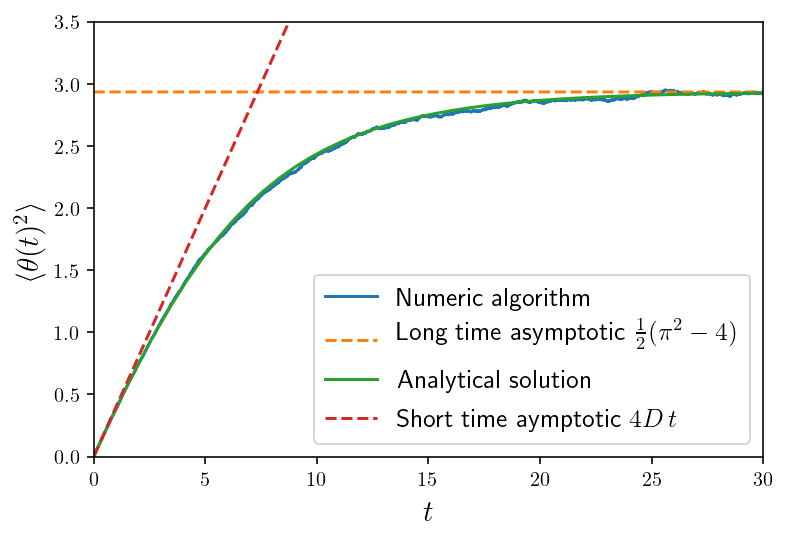

In [218]:
plt.plot(tiempos[:], mean_true_theta_square_t[:], label= 'Numeric algorithm')

plt.plot(tiempos, (1./2*(np.pi**2-4))*np.ones(len(tiempos)),#
         label= r'Long time asymptotic $\frac{1}{2}(\pi^2 - 4)$', linestyle='--')


plt.plot(tiempos2, thetasqr_numint_mean_t, label='Analytical solution')
plt.plot(tiempos2, 4*D*np.array(tiempos2), label = r'Short time aymptotic $4D\,t$', linestyle='--')

#plt.plot(tiempos2, var_theta_num_t, label = 'Numerical Integration')


#plt.plot(tiempos, np.arccos(np.exp(-(2*D*np.array(tiempos)))), label='Analytic')
plt.legend(fontsize=13, loc='lower right')
plt.xlabel(r"$t$", fontsize=15)
plt.ylabel(r"$\langle \theta(t)^2 \rangle$", fontsize=15);
plt.xlim(0,30)
plt.ylim(0,3.5);
plt.savefig("Theta_Square_t_S&L_Asymptotics.png", dpi=200)

In [165]:
D

0.1

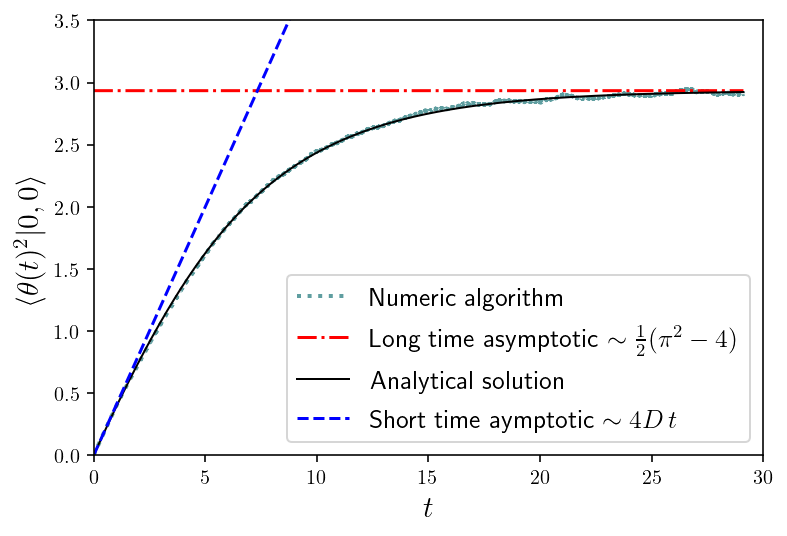

In [654]:
plt.plot(tiempos[:], mean_true_theta_square_t[:], label= 'Numeric algorithm', color='cadetblue', 
         linestyle=':', linewidth=2)

plt.plot(tiempos, (1./2*(np.pi**2-4))*np.ones(len(tiempos)),#
         label= r'Long time asymptotic  $\sim \frac{1}{2}(\pi^2 - 4)$', linestyle='-.', color='r')


plt.plot(tiempos2, thetasqr_numint_mean_t, label='Analytical solution', color='k', linewidth=1, linestyle='-')
plt.plot(tiempos, 4*D*np.array(tiempos), label = r'Short time aymptotic  $ \sim 4D\,t$', linestyle='--', color='b')

#plt.plot(tiempos, np.power(tiempos,(1)), label = r'$\sim t^{3/4}$')
#plt.plot(tiempos, np.log(tiempos), label = r'$\log{t}$')
#plt.plot(tiempos, np.arccos(tiempos))

#plt.plot(tiempos, np.arccos(np.exp(-(2*D*np.array(tiempos)))), label='Analytic')
plt.legend(fontsize=13, loc='lower right')
plt.xlabel(r"$t$", fontsize=15)
plt.ylabel(r"$\langle \theta(t)^2|0,0 \rangle$", fontsize=15);
plt.xlim(0,30)
plt.ylim(0,3.5);
#plt.savefig("Theta_Square_t_S&L_Asymptotics.png", dpi=200)

(0.0, 3.5)

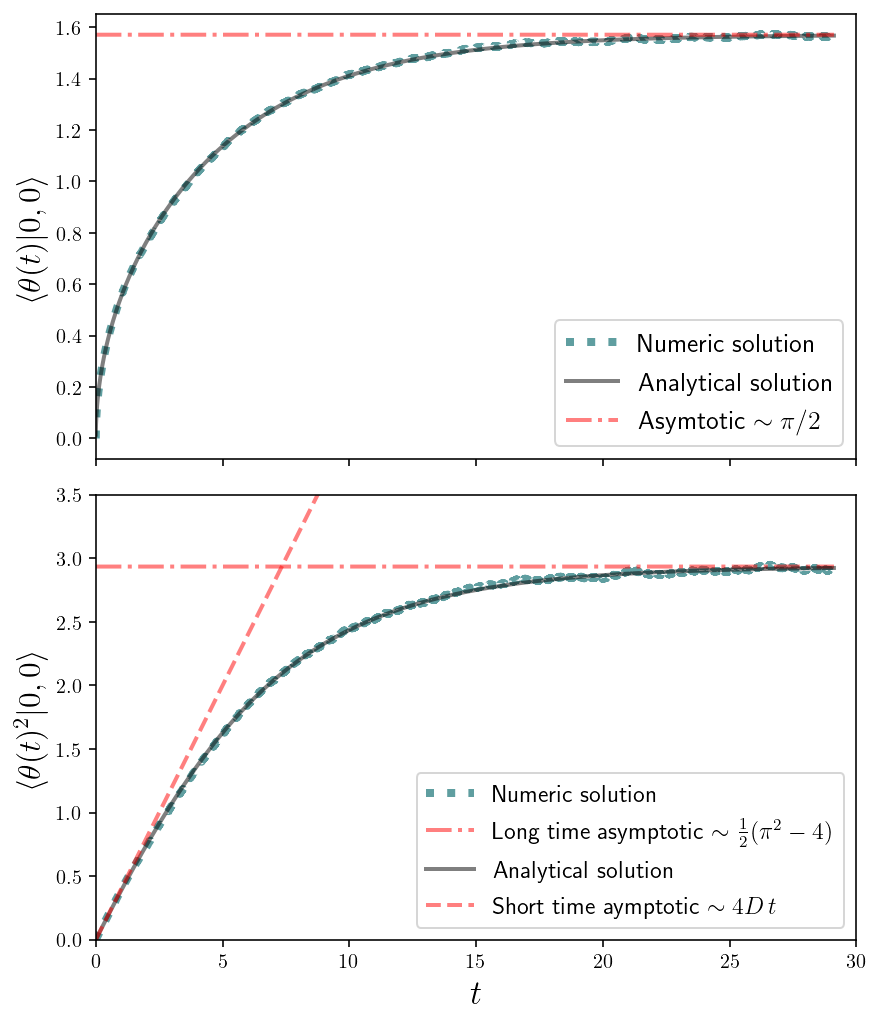

In [641]:
fig, ax = plt.subplots(nrows=2,ncols=1, sharex=True, figsize=(6,7),constrained_layout=True)

ax[0].plot(tiempos, mean_thetas_t, label= 'Numeric solution', color='cadetblue',
         alpha=1.0, linestyle=':',linewidth=4)
#plt.plot(tiempos, np.arccos(np.exp(-(2*D*np.array(tiempos)))), label='Analytic')
ax[0].plot(tiempos2[:], theta_numint_mean_t[:], label='Analytical solution', linewidth=2,
         linestyle='-', color='k', alpha=.5)
ax[0].plot(tiempos2[:], np.pi/2*np.ones_like(tiempos2[:]), label=r'Asymtotic $\sim \pi/2$',
           color='r', linestyle='-.',linewidth=2, alpha=.5)
ax[0].legend(fontsize=13, loc='lower right')
#ax[0].set_xlabel(r"$t$", fontsize=15)
ax[0].set_ylabel(r"$\langle \theta(t)|0,0 \rangle$", fontsize=16);
#plt.savefig("Mean_of_theta_t_Num_Ana.png", dpi=200)

ax[1].plot(tiempos[:], mean_true_theta_square_t[:], label= 'Numeric solution', color='cadetblue', 
         linestyle=':', linewidth=4)
ax[1].plot(tiempos, (1./2*(np.pi**2-4))*np.ones(len(tiempos)),
         label= r'Long time asymptotic  $\sim \frac{1}{2}(\pi^2 - 4)$', linestyle='-.',
           color='r',linewidth=2, alpha=.5)
ax[1].plot(tiempos2, thetasqr_numint_mean_t, label='Analytical solution',
           color='k', linestyle='-',linewidth=2, alpha=.5)
ax[1].plot(tiempos, 4*D*np.array(tiempos), label = r'Short time aymptotic  $ \sim 4D\,t$',
               linestyle='--', color='r',linewidth=2,alpha=.5)
ax[1].legend(fontsize=12, loc='lower right')
ax[1].set_xlabel(r"$t$", fontsize=17)
ax[1].set_ylabel(r"$\langle \theta(t)^2|0,0 \rangle$", fontsize=16);
ax[1].set_xlim(0,30)
ax[1].set_ylim(0,3.5)
#plt.tight_layout()
#plt.savefig("1st2nd_Theta_Moments.png", dpi=250);


In [166]:
!pwd

/Users/adrianovaldesgomez/Documents/Adriano_Programming/AnalyticNumeric_theta_t_12102019


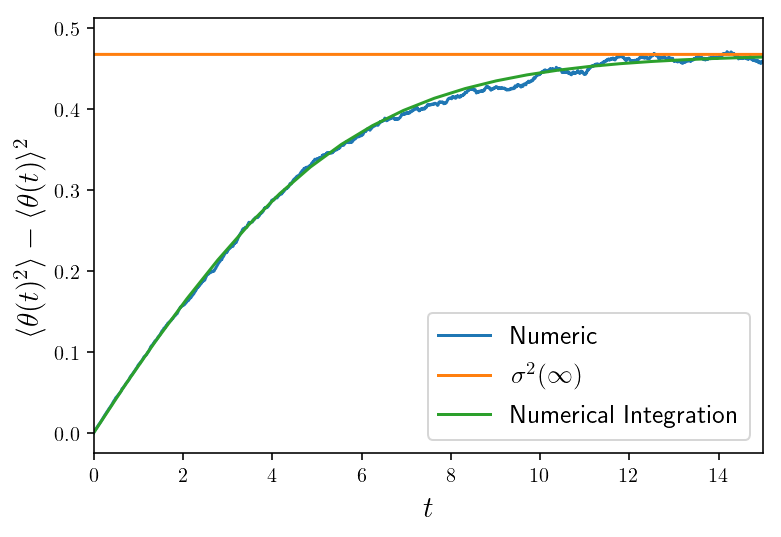

In [176]:
plt.plot(tiempos[:], mean_thetas_square_t[:], label= 'Numeric')
#plt.plot(tiempos[:2000], s2[:2000], label= 'Analictical Short time Sol.', linestyle='--')
#plt.plot(tiempos[:9000], s3[:9000], label= 'Fitted linear Short time', linestyle='--')
#plt.plot(tiempos[:2000], s4[:2000], label= 'Short time', linestyle='--')
#plt.plot(tiempos[:2000], s5[:2000], label= 'Short time', linestyle='--')
#plt.plot(tiempos[-9000:], s4[-9000:], label= 'Short time', linestyle='--')
#plt.plot(tiempos[:9000], s7[:9000], label= 'Correct Variance', linestyle='--')
plt.plot(tiempos, var*np.ones(len(tiempos)), label= r'$\sigma^2(\infty)$')

plt.plot(tiempos2, var_theta_num_t, label = 'Numerical Integration')


#plt.plot(tiempos, np.arccos(np.exp(-(2*D*np.array(tiempos)))), label='Analytic')
plt.legend(fontsize=13)
plt.xlabel(r"$t$", fontsize=15)
plt.ylabel(r"$\langle \theta(t)^2 \rangle - \langle \theta(t) \rangle^2$", fontsize=15);
plt.xlim(0,15)
#plt.ylim(0,0.000000000000000000000000001);
plt.savefig("Sigma_Square_t_Num_Ana.png", dpi=200)

In [344]:
mean_cos_thetas_t =[]
for ensamble in thetas:
    ensamble = np.array(ensamble)
    cos_ens = np.cos(ensamble)
    mean_cos_thetas_t.append(np.mean(cos_ens))

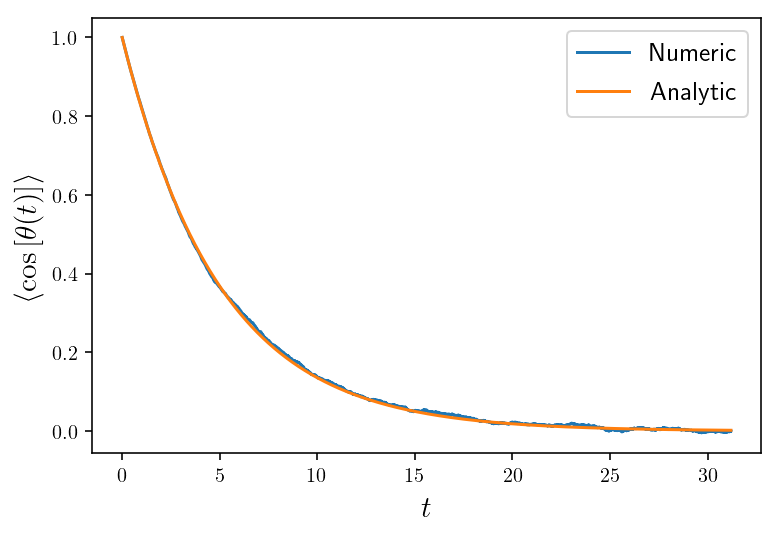

In [178]:
plt.plot(tiempos, mean_cos_thetas_t, label= 'Numeric')
plt.plot(tiempos, np.exp(-(2*D*np.array(tiempos))), label='Analytic')
plt.legend(fontsize=13)
plt.xlabel(r"$t$", fontsize=15)
plt.ylabel(r"$\langle \cos{[\theta(t)]} \rangle$", fontsize=15)
plt.savefig("Mean_of_cos_theta_t_Num_Ana.png", dpi=200)

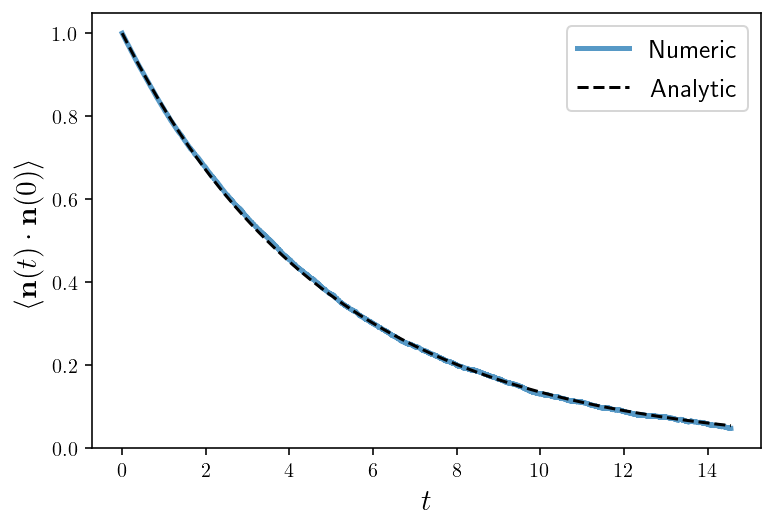

In [368]:
plt.plot(tiempos, mean_cos_thetas_t, label= 'Numeric', alpha=.75, linewidth=2.5)
#plt.scatter(tiempos, mean_cos_thetas_t, label= 'Numeric', marker='o', s=5, alpha=.05)
plt.plot(tiempos, np.exp(-(2*D*np.array(tiempos))), label='Analytic', color='k', linewidth=1.5, linestyle='--')
plt.legend(fontsize=13)
plt.xlabel(r"$t$", fontsize=15)
plt.ylabel(r"$\langle \mathbf{n}(t)\cdot \mathbf{n}(0) \rangle$", fontsize=15);
#plt.savefig("Mean_of_cos_theta_t_Num_Ana.png", dpi=200);

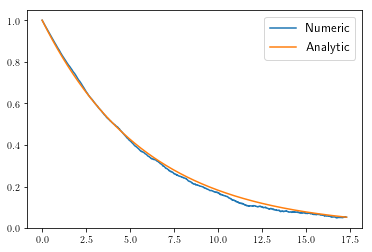

In [65]:
plt.plot(tiempos, np.cos(np.array(mean_thetas_t)), label= 'Numeric')
plt.plot(tiempos, np.exp(-(1.7*D*np.array(tiempos))), label='Analytic')
plt.legend(fontsize=13)

## Animation of free diffusion Analytic vs Numeric

In [2]:
%pwd

'/Users/adrianovaldesgomez/Documents/Adriano_Programming'

In [75]:
%cd ..

/Users/adrianovaldesgomez/Documents/Adriano_Programming


In [76]:
!mkdir Sim_Analytic_vs_Numeric_free_diff

In [3]:
%cd Sim_Analytic_vs_Numeric_free_diff/

/Users/adrianovaldesgomez/Documents/Adriano_Programming/Sim_Analytic_vs_Numeric_free_diff


/Users/adrianovaldesgomez/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


RuntimeError: LaTeX was not able to process the following string:
b'Time = 48.5896 seg'
Here is the full report generated by LaTeX: 



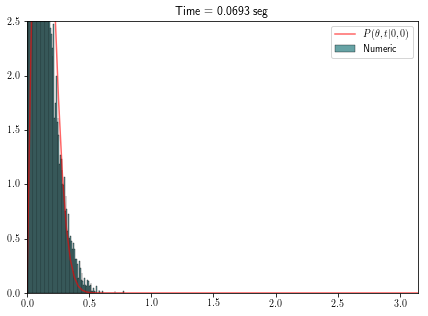

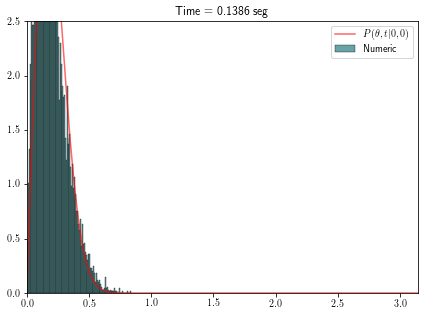

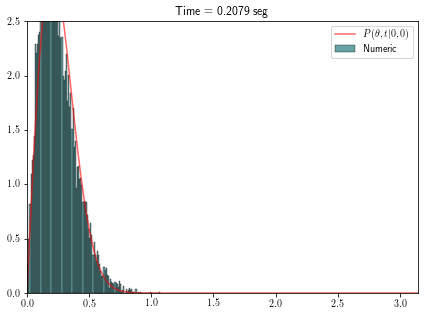

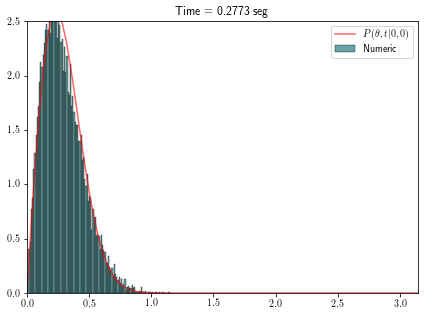

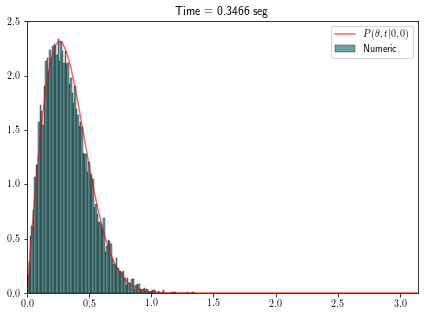

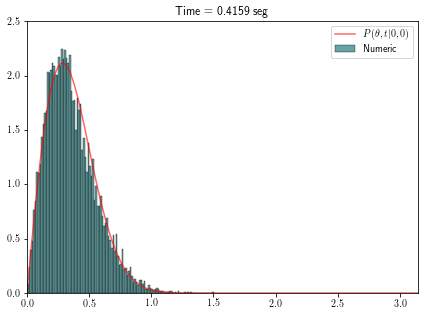

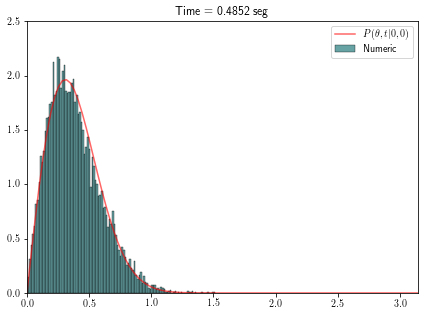

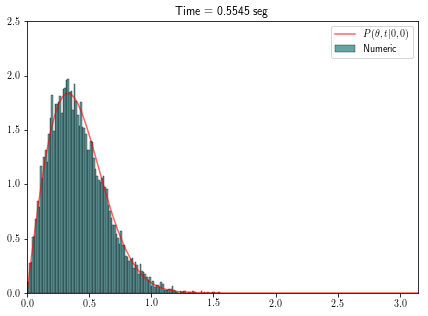

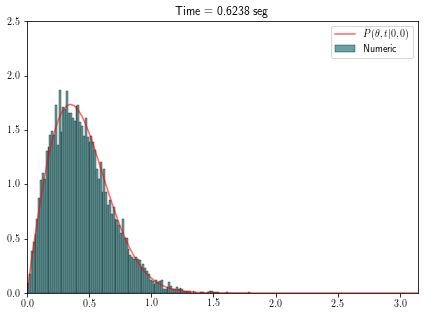

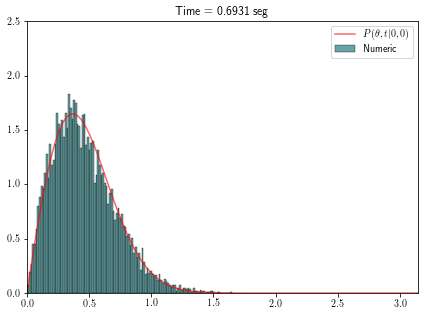

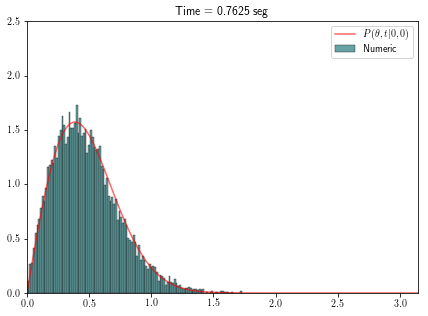

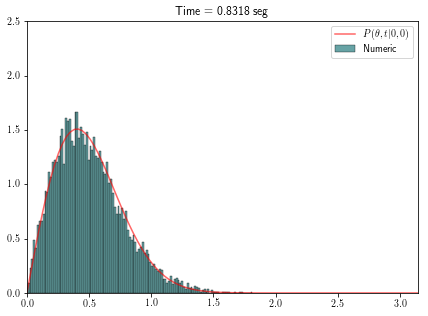

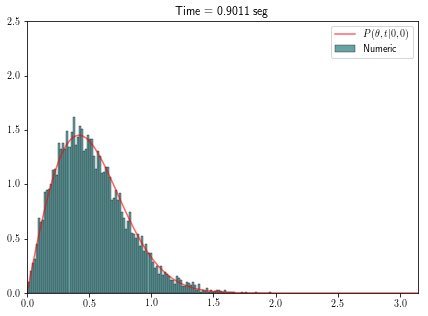

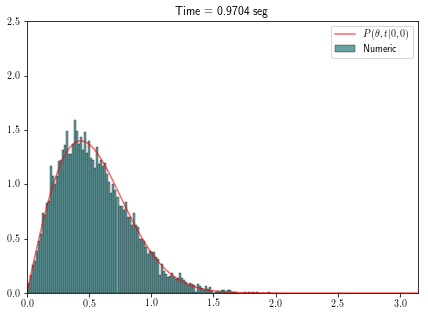

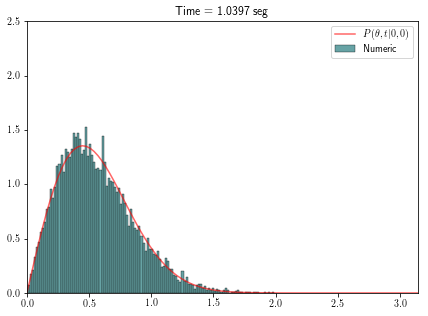

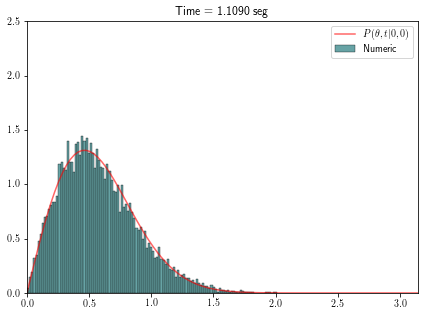

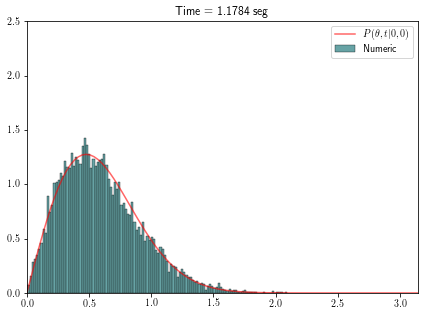

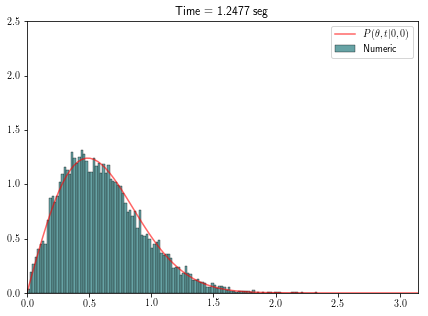

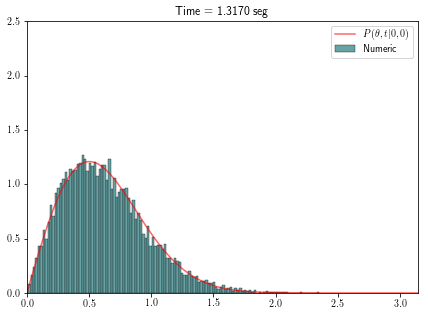

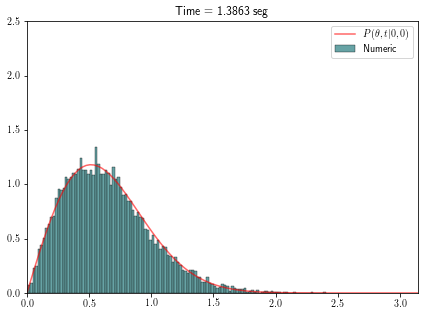

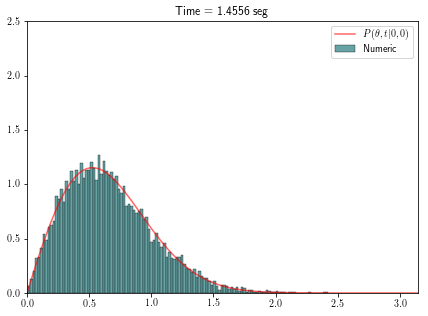

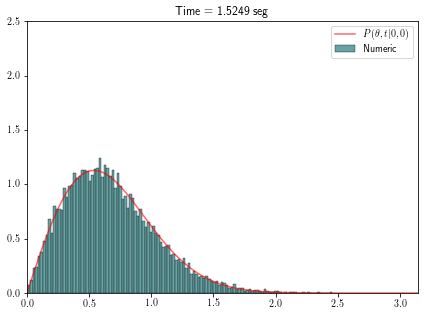

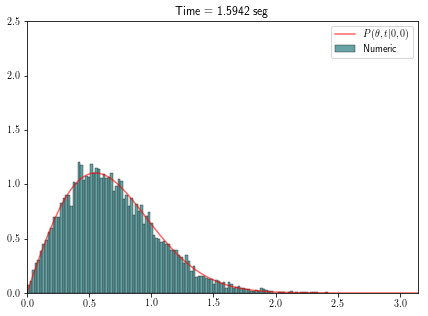

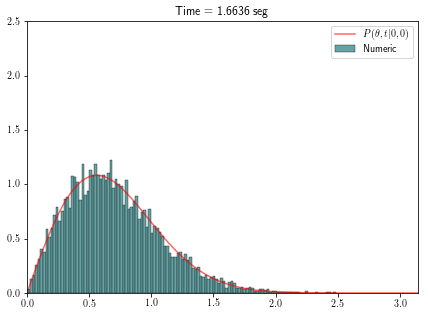

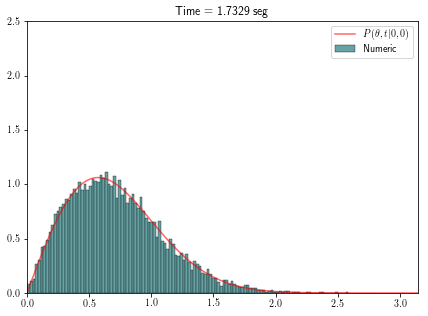

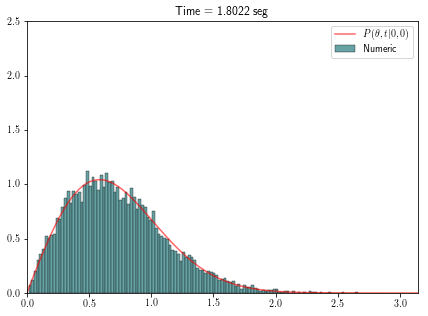

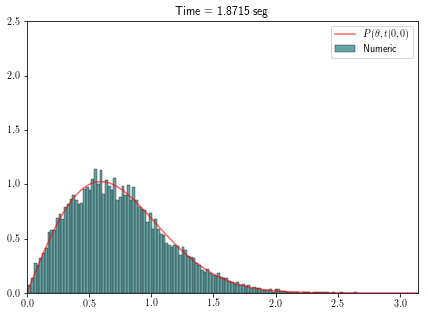

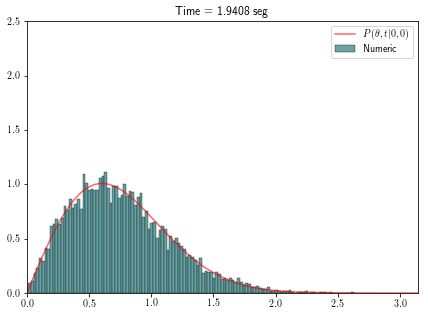

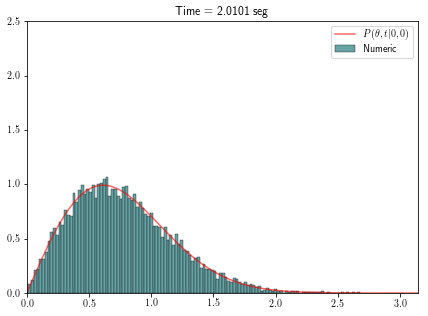

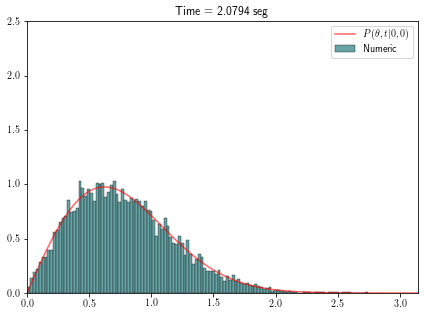

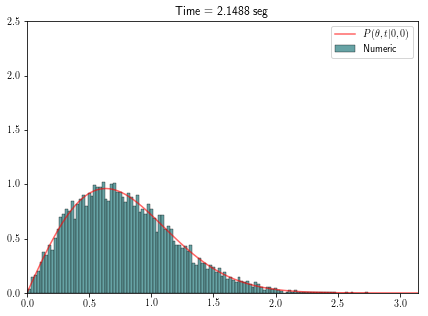

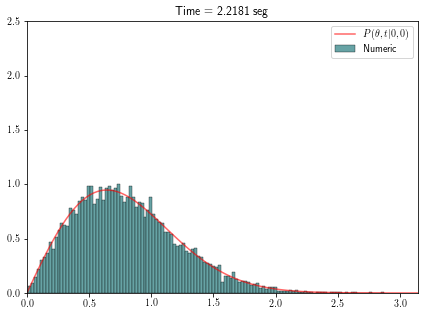

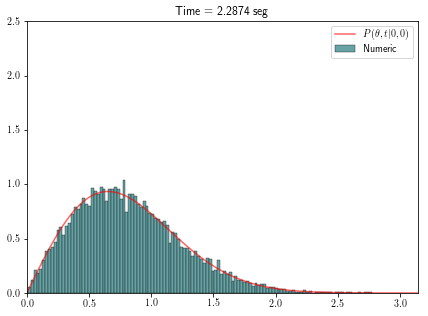

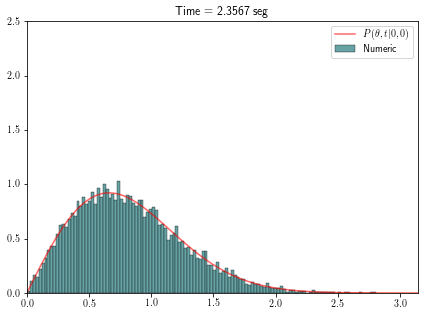

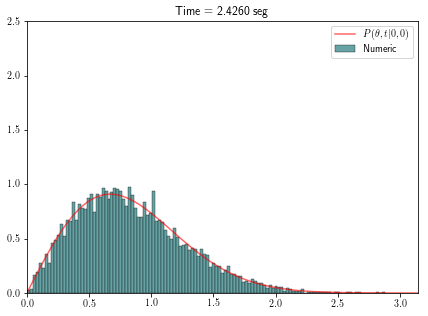

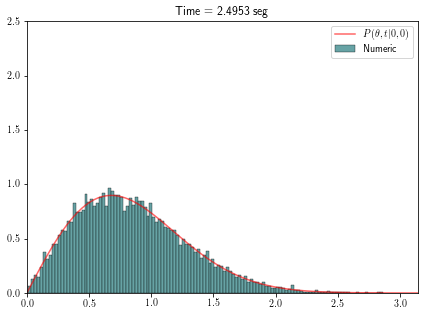

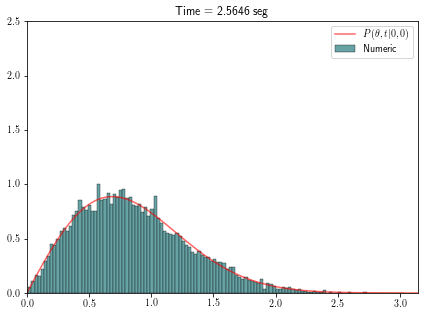

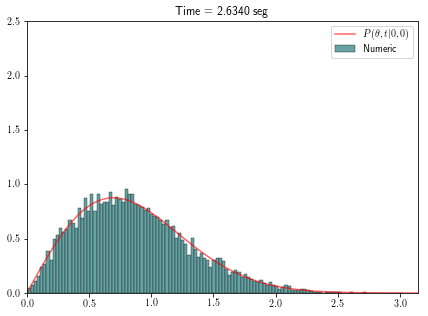

In [ ]:
for n in range(0,1000):
    Num_Analytic(n+1)

In [5]:
!mencoder "mf://*.png" -o Sim_free_diff_NumvsAnalytic_01.avi -ovc lavc -lavcopts vcodec=msmpeg4v2:autoaspect:vbitrate=2160000:mbd=2:keyint=132:vqblur=1.0:cmp=2:subcmp=2:dia=2:o=mpv_flags=+mv0:last_pred=3 -fps 3

MEncoder 1.3.0-4.2.1 (C) 2000-2016 MPlayer Team
224 audio & 451 video codecs
success: format: 16  data: 0x0 - 0x0
MF file format detected.
[mf] search expr: *.png
[mf] number of files: 700 (5600)
[demux_mf] file type was not set! trying 'type=png'...
VIDEO:  [MPNG]  0x0  24bpp  25.000 fps    0.0 kbps ( 0.0 kbyte/s)
[V] filefmt:16  fourcc:0x474E504D  size:0x0  fps:25.000  ftime:=0.0400
Input fps will be interpreted as 3.000 instead.
libavcodec version 57.24.102 (internal)
Opening video filter: [expand osd=1]
Expand: -1 x -1, -1 ; -1, osd: 1, aspect: 0.000000, round: 1
Opening video decoder: [ffmpeg] FFmpeg's libavcodec codec family
Selected video codec: [ffpng] vfm: ffmpeg (FFmpeg PNG)
Could not find matching colorspace - retrying with -vf scale...
Opening video filter: [scale]
Movie-Aspect is undefined - no prescaling applied.
[swscaler @ 0x104006410]bicubic scaler, from rgba to yuv420p using MMXEXT
videocodec: libavcodec (700x500 fourcc=3234504d [MP42])
[VE_LAVC] High quality encoding

Pos:  13.0s     39f ( 5%)  0.00fps Trem:   0min   8mb  A-V:0.000 [277:0]
[msmpeg4v2 @ 0x103fecfe0]AVFrame.format is not set
[msmpeg4v2 @ 0x103fecfe0]AVFrame.width or height is not set
Pos:  13.3s     40f ( 5%)  0.00fps Trem:   0min   8mb  A-V:0.000 [277:0]
[msmpeg4v2 @ 0x103fecfe0]AVFrame.format is not set
[msmpeg4v2 @ 0x103fecfe0]AVFrame.width or height is not set
Pos:  13.7s     41f ( 5%)  0.00fps Trem:   0min   9mb  A-V:0.000 [277:0]
[msmpeg4v2 @ 0x103fecfe0]AVFrame.format is not set
[msmpeg4v2 @ 0x103fecfe0]AVFrame.width or height is not set
Pos:  14.0s     42f ( 6%)  0.00fps Trem:   0min   7mb  A-V:0.000 [276:0]
[msmpeg4v2 @ 0x103fecfe0]AVFrame.format is not set
[msmpeg4v2 @ 0x103fecfe0]AVFrame.width or height is not set
Pos:  14.3s     43f ( 6%)  0.00fps Trem:   0min   7mb  A-V:0.000 [277:0]
[msmpeg4v2 @ 0x103fecfe0]AVFrame.format is not set
[msmpeg4v2 @ 0x103fecfe0]AVFrame.width or height is not set
Pos:  14.7s     44f ( 6%)  0.00fps Trem:   0min   8mb  A-V:0.000 [277:0]
[msmpeg

Pos:  28.3s     85f (12%) 49.91fps Trem:   0min   7mb  A-V:0.000 [276:0]
[msmpeg4v2 @ 0x103fecfe0]AVFrame.format is not set
[msmpeg4v2 @ 0x103fecfe0]AVFrame.width or height is not set
Pos:  28.7s     86f (12%) 50.09fps Trem:   0min   7mb  A-V:0.000 [275:0]
[msmpeg4v2 @ 0x103fecfe0]AVFrame.format is not set
[msmpeg4v2 @ 0x103fecfe0]AVFrame.width or height is not set
Pos:  29.0s     87f (12%) 50.20fps Trem:   0min   7mb  A-V:0.000 [276:0]
[msmpeg4v2 @ 0x103fecfe0]AVFrame.format is not set
[msmpeg4v2 @ 0x103fecfe0]AVFrame.width or height is not set
Pos:  29.3s     88f (12%) 50.26fps Trem:   0min   8mb  A-V:0.000 [275:0]
[msmpeg4v2 @ 0x103fecfe0]AVFrame.format is not set
[msmpeg4v2 @ 0x103fecfe0]AVFrame.width or height is not set
Pos:  29.7s     89f (12%) 50.37fps Trem:   0min   8mb  A-V:0.000 [275:0]
[msmpeg4v2 @ 0x103fecfe0]AVFrame.format is not set
[msmpeg4v2 @ 0x103fecfe0]AVFrame.width or height is not set
Pos:  30.0s     90f (12%) 50.51fps Trem:   0min   8mb  A-V:0.000 [275:0]
[msmpeg

Pos:  43.3s    130f (18%) 53.61fps Trem:   0min   7mb  A-V:0.000 [275:0]
[msmpeg4v2 @ 0x103fecfe0]AVFrame.format is not set
[msmpeg4v2 @ 0x103fecfe0]AVFrame.width or height is not set
Pos:  43.7s    131f (18%) 53.67fps Trem:   0min   7mb  A-V:0.000 [275:0]
[msmpeg4v2 @ 0x103fecfe0]AVFrame.format is not set
[msmpeg4v2 @ 0x103fecfe0]AVFrame.width or height is not set
Pos:  44.0s    132f (18%) 53.68fps Trem:   0min   8mb  A-V:0.000 [275:0]
[msmpeg4v2 @ 0x103fecfe0]AVFrame.format is not set
[msmpeg4v2 @ 0x103fecfe0]AVFrame.width or height is not set
Pos:  44.3s    133f (19%) 53.82fps Trem:   0min   7mb  A-V:0.000 [278:0]
[msmpeg4v2 @ 0x103fecfe0]AVFrame.format is not set
[msmpeg4v2 @ 0x103fecfe0]AVFrame.width or height is not set
Pos:  44.7s    134f (19%) 53.90fps Trem:   0min   7mb  A-V:0.000 [278:0]
[msmpeg4v2 @ 0x103fecfe0]AVFrame.format is not set
[msmpeg4v2 @ 0x103fecfe0]AVFrame.width or height is not set
Pos:  45.0s    135f (19%) 53.98fps Trem:   0min   7mb  A-V:0.000 [278:0]
[msmpeg

Pos:  58.3s    175f (25%) 56.16fps Trem:   0min   7mb  A-V:0.000 [274:0]
[msmpeg4v2 @ 0x103fecfe0]AVFrame.format is not set
[msmpeg4v2 @ 0x103fecfe0]AVFrame.width or height is not set
Pos:  58.7s    176f (25%) 56.21fps Trem:   0min   7mb  A-V:0.000 [274:0]
[msmpeg4v2 @ 0x103fecfe0]AVFrame.format is not set
[msmpeg4v2 @ 0x103fecfe0]AVFrame.width or height is not set
Pos:  59.0s    177f (25%) 56.24fps Trem:   0min   7mb  A-V:0.000 [274:0]
[msmpeg4v2 @ 0x103fecfe0]AVFrame.format is not set
[msmpeg4v2 @ 0x103fecfe0]AVFrame.width or height is not set
Pos:  59.3s    178f (25%) 56.33fps Trem:   0min   7mb  A-V:0.000 [274:0]
[msmpeg4v2 @ 0x103fecfe0]AVFrame.format is not set
[msmpeg4v2 @ 0x103fecfe0]AVFrame.width or height is not set
Pos:  59.7s    179f (25%) 56.40fps Trem:   0min   7mb  A-V:0.000 [274:0]
[msmpeg4v2 @ 0x103fecfe0]AVFrame.format is not set
[msmpeg4v2 @ 0x103fecfe0]AVFrame.width or height is not set
Pos:  60.0s    180f (25%) 56.43fps Trem:   0min   7mb  A-V:0.000 [273:0]
[msmpeg

Pos:  73.7s    221f (31%) 57.64fps Trem:   0min   7mb  A-V:0.000 [272:0]
[msmpeg4v2 @ 0x103fecfe0]AVFrame.format is not set
[msmpeg4v2 @ 0x103fecfe0]AVFrame.width or height is not set
Pos:  74.0s    222f (31%) 57.68fps Trem:   0min   7mb  A-V:0.000 [272:0]
[msmpeg4v2 @ 0x103fecfe0]AVFrame.format is not set
[msmpeg4v2 @ 0x103fecfe0]AVFrame.width or height is not set
Pos:  74.3s    223f (31%) 57.73fps Trem:   0min   7mb  A-V:0.000 [272:0]
[msmpeg4v2 @ 0x103fecfe0]AVFrame.format is not set
[msmpeg4v2 @ 0x103fecfe0]AVFrame.width or height is not set
Pos:  74.7s    224f (32%) 57.76fps Trem:   0min   7mb  A-V:0.000 [272:0]
[msmpeg4v2 @ 0x103fecfe0]AVFrame.format is not set
[msmpeg4v2 @ 0x103fecfe0]AVFrame.width or height is not set
Pos:  75.0s    225f (32%) 57.77fps Trem:   0min   7mb  A-V:0.000 [272:0]
[msmpeg4v2 @ 0x103fecfe0]AVFrame.format is not set
[msmpeg4v2 @ 0x103fecfe0]AVFrame.width or height is not set
Pos:  75.3s    226f (32%) 57.80fps Trem:   0min   7mb  A-V:0.000 [272:0]
[msmpeg

Pos:  89.3s    268f (38%) 58.75fps Trem:   0min   7mb  A-V:0.000 [272:0]
[msmpeg4v2 @ 0x103fecfe0]AVFrame.format is not set
[msmpeg4v2 @ 0x103fecfe0]AVFrame.width or height is not set
Pos:  89.7s    269f (38%) 58.72fps Trem:   0min   7mb  A-V:0.000 [272:0]
[msmpeg4v2 @ 0x103fecfe0]AVFrame.format is not set
[msmpeg4v2 @ 0x103fecfe0]AVFrame.width or height is not set
Pos:  90.0s    270f (38%) 58.75fps Trem:   0min   7mb  A-V:0.000 [272:0]
[msmpeg4v2 @ 0x103fecfe0]AVFrame.format is not set
[msmpeg4v2 @ 0x103fecfe0]AVFrame.width or height is not set
Pos:  90.3s    271f (38%) 58.76fps Trem:   0min   7mb  A-V:0.000 [272:0]
[msmpeg4v2 @ 0x103fecfe0]AVFrame.format is not set
[msmpeg4v2 @ 0x103fecfe0]AVFrame.width or height is not set
Pos:  90.7s    272f (38%) 58.79fps Trem:   0min   7mb  A-V:0.000 [272:0]
[msmpeg4v2 @ 0x103fecfe0]AVFrame.format is not set
[msmpeg4v2 @ 0x103fecfe0]AVFrame.width or height is not set
Pos:  91.0s    273f (39%) 58.82fps Trem:   0min   7mb  A-V:0.000 [272:0]
[msmpeg

Pos: 104.7s    314f (44%) 59.17fps Trem:   0min   7mb  A-V:0.000 [271:0]
[msmpeg4v2 @ 0x103fecfe0]AVFrame.format is not set
[msmpeg4v2 @ 0x103fecfe0]AVFrame.width or height is not set
Pos: 105.0s    315f (45%) 59.18fps Trem:   0min   7mb  A-V:0.000 [271:0]
[msmpeg4v2 @ 0x103fecfe0]AVFrame.format is not set
[msmpeg4v2 @ 0x103fecfe0]AVFrame.width or height is not set
Pos: 105.3s    316f (45%) 59.20fps Trem:   0min   7mb  A-V:0.000 [270:0]
[msmpeg4v2 @ 0x103fecfe0]AVFrame.format is not set
[msmpeg4v2 @ 0x103fecfe0]AVFrame.width or height is not set
Pos: 105.7s    317f (45%) 59.23fps Trem:   0min   7mb  A-V:0.000 [270:0]
[msmpeg4v2 @ 0x103fecfe0]AVFrame.format is not set
[msmpeg4v2 @ 0x103fecfe0]AVFrame.width or height is not set
Pos: 106.0s    318f (45%) 59.25fps Trem:   0min   7mb  A-V:0.000 [270:0]
[msmpeg4v2 @ 0x103fecfe0]AVFrame.format is not set
[msmpeg4v2 @ 0x103fecfe0]AVFrame.width or height is not set
Pos: 106.3s    319f (45%) 59.24fps Trem:   0min   7mb  A-V:0.000 [270:0]
[msmpeg

Pos: 120.3s    361f (51%) 59.81fps Trem:   0min   7mb  A-V:0.000 [269:0]
[msmpeg4v2 @ 0x103fecfe0]AVFrame.format is not set
[msmpeg4v2 @ 0x103fecfe0]AVFrame.width or height is not set
Pos: 120.7s    362f (51%) 59.81fps Trem:   0min   7mb  A-V:0.000 [269:0]
[msmpeg4v2 @ 0x103fecfe0]AVFrame.format is not set
[msmpeg4v2 @ 0x103fecfe0]AVFrame.width or height is not set
Pos: 121.0s    363f (51%) 59.83fps Trem:   0min   7mb  A-V:0.000 [269:0]
[msmpeg4v2 @ 0x103fecfe0]AVFrame.format is not set
[msmpeg4v2 @ 0x103fecfe0]AVFrame.width or height is not set
Pos: 121.3s    364f (52%) 59.85fps Trem:   0min   7mb  A-V:0.000 [269:0]
[msmpeg4v2 @ 0x103fecfe0]AVFrame.format is not set
[msmpeg4v2 @ 0x103fecfe0]AVFrame.width or height is not set
Pos: 121.7s    365f (52%) 59.86fps Trem:   0min   7mb  A-V:0.000 [269:0]
[msmpeg4v2 @ 0x103fecfe0]AVFrame.format is not set
[msmpeg4v2 @ 0x103fecfe0]AVFrame.width or height is not set
Pos: 122.0s    366f (52%) 59.85fps Trem:   0min   7mb  A-V:0.000 [269:0]
[msmpeg

Pos: 135.7s    407f (58%) 60.08fps Trem:   0min   7mb  A-V:0.000 [270:0]
[msmpeg4v2 @ 0x103fecfe0]AVFrame.format is not set
[msmpeg4v2 @ 0x103fecfe0]AVFrame.width or height is not set
Pos: 136.0s    408f (58%) 60.11fps Trem:   0min   7mb  A-V:0.000 [270:0]
[msmpeg4v2 @ 0x103fecfe0]AVFrame.format is not set
[msmpeg4v2 @ 0x103fecfe0]AVFrame.width or height is not set
Pos: 136.3s    409f (58%) 60.12fps Trem:   0min   7mb  A-V:0.000 [270:0]
[msmpeg4v2 @ 0x103fecfe0]AVFrame.format is not set
[msmpeg4v2 @ 0x103fecfe0]AVFrame.width or height is not set
Pos: 136.7s    410f (58%) 60.09fps Trem:   0min   7mb  A-V:0.000 [270:0]
[msmpeg4v2 @ 0x103fecfe0]AVFrame.format is not set
[msmpeg4v2 @ 0x103fecfe0]AVFrame.width or height is not set
Pos: 137.0s    411f (58%) 60.10fps Trem:   0min   7mb  A-V:0.000 [270:0]
[msmpeg4v2 @ 0x103fecfe0]AVFrame.format is not set
[msmpeg4v2 @ 0x103fecfe0]AVFrame.width or height is not set
Pos: 137.3s    412f (58%) 60.11fps Trem:   0min   7mb  A-V:0.000 [270:0]
[msmpeg

Pos: 151.3s    454f (64%) 60.46fps Trem:   0min   7mb  A-V:0.000 [269:0]
[msmpeg4v2 @ 0x103fecfe0]AVFrame.format is not set
[msmpeg4v2 @ 0x103fecfe0]AVFrame.width or height is not set
Pos: 151.7s    455f (65%) 60.48fps Trem:   0min   7mb  A-V:0.000 [269:0]
[msmpeg4v2 @ 0x103fecfe0]AVFrame.format is not set
[msmpeg4v2 @ 0x103fecfe0]AVFrame.width or height is not set
Pos: 152.0s    456f (65%) 60.49fps Trem:   0min   7mb  A-V:0.000 [269:0]
[msmpeg4v2 @ 0x103fecfe0]AVFrame.format is not set
[msmpeg4v2 @ 0x103fecfe0]AVFrame.width or height is not set
Pos: 152.3s    457f (65%) 60.51fps Trem:   0min   7mb  A-V:0.000 [269:0]
[msmpeg4v2 @ 0x103fecfe0]AVFrame.format is not set
[msmpeg4v2 @ 0x103fecfe0]AVFrame.width or height is not set
Pos: 152.7s    458f (65%) 60.53fps Trem:   0min   7mb  A-V:0.000 [269:0]
[msmpeg4v2 @ 0x103fecfe0]AVFrame.format is not set
[msmpeg4v2 @ 0x103fecfe0]AVFrame.width or height is not set
Pos: 153.0s    459f (65%) 60.51fps Trem:   0min   7mb  A-V:0.000 [269:0]
[msmpeg

Pos: 166.7s    500f (71%) 60.72fps Trem:   0min   7mb  A-V:0.000 [269:0]
[msmpeg4v2 @ 0x103fecfe0]AVFrame.format is not set
[msmpeg4v2 @ 0x103fecfe0]AVFrame.width or height is not set
Pos: 167.0s    501f (71%) 60.73fps Trem:   0min   7mb  A-V:0.000 [269:0]
[msmpeg4v2 @ 0x103fecfe0]AVFrame.format is not set
[msmpeg4v2 @ 0x103fecfe0]AVFrame.width or height is not set
Pos: 167.3s    502f (71%) 60.75fps Trem:   0min   7mb  A-V:0.000 [269:0]
[msmpeg4v2 @ 0x103fecfe0]AVFrame.format is not set
[msmpeg4v2 @ 0x103fecfe0]AVFrame.width or height is not set
Pos: 167.7s    503f (71%) 60.75fps Trem:   0min   7mb  A-V:0.000 [269:0]
[msmpeg4v2 @ 0x103fecfe0]AVFrame.format is not set
[msmpeg4v2 @ 0x103fecfe0]AVFrame.width or height is not set
Pos: 168.0s    504f (72%) 60.76fps Trem:   0min   7mb  A-V:0.000 [269:0]
[msmpeg4v2 @ 0x103fecfe0]AVFrame.format is not set
[msmpeg4v2 @ 0x103fecfe0]AVFrame.width or height is not set
Pos: 168.3s    505f (72%) 60.77fps Trem:   0min   7mb  A-V:0.000 [269:0]
[msmpeg

Pos: 182.0s    546f (78%) 60.96fps Trem:   0min   7mb  A-V:0.000 [269:0]
[msmpeg4v2 @ 0x103fecfe0]AVFrame.format is not set
[msmpeg4v2 @ 0x103fecfe0]AVFrame.width or height is not set
Pos: 182.3s    547f (78%) 60.96fps Trem:   0min   7mb  A-V:0.000 [269:0]
[msmpeg4v2 @ 0x103fecfe0]AVFrame.format is not set
[msmpeg4v2 @ 0x103fecfe0]AVFrame.width or height is not set
Pos: 182.7s    548f (78%) 60.97fps Trem:   0min   7mb  A-V:0.000 [269:0]
[msmpeg4v2 @ 0x103fecfe0]AVFrame.format is not set
[msmpeg4v2 @ 0x103fecfe0]AVFrame.width or height is not set
Pos: 183.0s    549f (78%) 60.99fps Trem:   0min   7mb  A-V:0.000 [269:0]
[msmpeg4v2 @ 0x103fecfe0]AVFrame.format is not set
[msmpeg4v2 @ 0x103fecfe0]AVFrame.width or height is not set
Pos: 183.3s    550f (78%) 61.00fps Trem:   0min   7mb  A-V:0.000 [269:0]
[msmpeg4v2 @ 0x103fecfe0]AVFrame.format is not set
[msmpeg4v2 @ 0x103fecfe0]AVFrame.width or height is not set
Pos: 183.7s    551f (78%) 61.01fps Trem:   0min   7mb  A-V:0.000 [269:0]
[msmpeg

Pos: 197.7s    593f (84%) 61.20fps Trem:   0min   7mb  A-V:0.000 [269:0]
[msmpeg4v2 @ 0x103fecfe0]AVFrame.format is not set
[msmpeg4v2 @ 0x103fecfe0]AVFrame.width or height is not set
Pos: 198.0s    594f (84%) 61.22fps Trem:   0min   7mb  A-V:0.000 [269:0]
[msmpeg4v2 @ 0x103fecfe0]AVFrame.format is not set
[msmpeg4v2 @ 0x103fecfe0]AVFrame.width or height is not set
Pos: 198.3s    595f (85%) 61.23fps Trem:   0min   7mb  A-V:0.000 [269:0]
[msmpeg4v2 @ 0x103fecfe0]AVFrame.format is not set
[msmpeg4v2 @ 0x103fecfe0]AVFrame.width or height is not set
Pos: 198.7s    596f (85%) 61.21fps Trem:   0min   7mb  A-V:0.000 [269:0]
[msmpeg4v2 @ 0x103fecfe0]AVFrame.format is not set
[msmpeg4v2 @ 0x103fecfe0]AVFrame.width or height is not set
Pos: 199.0s    597f (85%) 61.22fps Trem:   0min   7mb  A-V:0.000 [269:0]
[msmpeg4v2 @ 0x103fecfe0]AVFrame.format is not set
[msmpeg4v2 @ 0x103fecfe0]AVFrame.width or height is not set
Pos: 199.3s    598f (85%) 61.24fps Trem:   0min   7mb  A-V:0.000 [269:0]
[msmpeg

Pos: 213.3s    640f (91%) 61.37fps Trem:   0min   7mb  A-V:0.000 [268:0]
[msmpeg4v2 @ 0x103fecfe0]AVFrame.format is not set
[msmpeg4v2 @ 0x103fecfe0]AVFrame.width or height is not set
Pos: 213.7s    641f (91%) 61.39fps Trem:   0min   7mb  A-V:0.000 [268:0]
[msmpeg4v2 @ 0x103fecfe0]AVFrame.format is not set
[msmpeg4v2 @ 0x103fecfe0]AVFrame.width or height is not set
Pos: 214.0s    642f (91%) 61.40fps Trem:   0min   7mb  A-V:0.000 [268:0]
[msmpeg4v2 @ 0x103fecfe0]AVFrame.format is not set
[msmpeg4v2 @ 0x103fecfe0]AVFrame.width or height is not set
Pos: 214.3s    643f (91%) 61.41fps Trem:   0min   7mb  A-V:0.000 [268:0]
[msmpeg4v2 @ 0x103fecfe0]AVFrame.format is not set
[msmpeg4v2 @ 0x103fecfe0]AVFrame.width or height is not set
Pos: 214.7s    644f (92%) 61.42fps Trem:   0min   7mb  A-V:0.000 [268:0]
[msmpeg4v2 @ 0x103fecfe0]AVFrame.format is not set
[msmpeg4v2 @ 0x103fecfe0]AVFrame.width or height is not set
Pos: 215.0s    645f (92%) 61.40fps Trem:   0min   7mb  A-V:0.000 [268:0]
[msmpeg

Pos: 229.0s    687f (98%) 61.59fps Trem:   0min   7mb  A-V:0.000 [269:0]
[msmpeg4v2 @ 0x103fecfe0]AVFrame.format is not set
[msmpeg4v2 @ 0x103fecfe0]AVFrame.width or height is not set
Pos: 229.3s    688f (98%) 61.60fps Trem:   0min   7mb  A-V:0.000 [269:0]
[msmpeg4v2 @ 0x103fecfe0]AVFrame.format is not set
[msmpeg4v2 @ 0x103fecfe0]AVFrame.width or height is not set
Pos: 229.7s    689f (98%) 61.61fps Trem:   0min   7mb  A-V:0.000 [269:0]
[msmpeg4v2 @ 0x103fecfe0]AVFrame.format is not set
[msmpeg4v2 @ 0x103fecfe0]AVFrame.width or height is not set
Pos: 230.0s    690f (98%) 61.59fps Trem:   0min   7mb  A-V:0.000 [269:0]
[msmpeg4v2 @ 0x103fecfe0]AVFrame.format is not set
[msmpeg4v2 @ 0x103fecfe0]AVFrame.width or height is not set
Pos: 230.3s    691f (98%) 61.60fps Trem:   0min   7mb  A-V:0.000 [269:0]
[msmpeg4v2 @ 0x103fecfe0]AVFrame.format is not set
[msmpeg4v2 @ 0x103fecfe0]AVFrame.width or height is not set
Pos: 230.7s    692f (98%) 61.60fps Trem:   0min   7mb  A-V:0.000 [268:0]
[msmpeg

In [6]:
%pwd

'/Users/adrianovaldesgomez/Documents/Adriano_Programming/Sim_Analytic_vs_Numeric_free_diff'

In [11]:
%cd ..

/Users/adrianovaldesgomez/Documents/Adriano_Programming


In [12]:
%pwd

'/Users/adrianovaldesgomez/Documents/Adriano_Programming'

In [14]:
%cd Animacion_Free_Diff_01/

/Users/adrianovaldesgomez/Documents/Adriano_Programming/Animacion_Free_Diff_01


In [10]:
%pwd

'/Users/adrianovaldesgomez/Documents/Adriano_Programming/Sim_Analytic_vs_Numeric_free_diff'

In [ ]:
imo

In [17]:
thetas = np.loadtxt("Sim_Thetas_t_01.txt")

In [131]:
ta = np.linspace(0,40,1000)
y = np.arccos(np.exp(-(2*D*ta/R)))

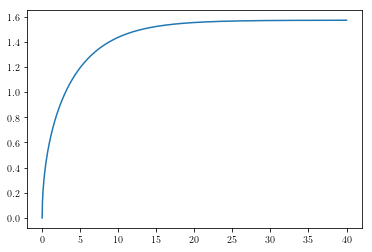

In [132]:
plt.plot(ta,y)

In [133]:
np.arccos(1)

0.0

In [134]:
np.arccos(-1)

3.141592653589793

In [462]:
from scipy import integrate
from scipy import special

In [71]:
integrate?

In [72]:
integrate.quad(lambda x: special.jv(5,x), 0, np.pi)

(0.030525157118376237, 3.388973226312179e-16)

In [73]:
special.legendre?

# Necesitamos calcular la siguientes integrales

$$\langle \theta(t) \rangle = \sum_{n=0}^{N} \frac{2n+1}{4\pi R^2} \int_{0}^{\pi} \theta P_{n}(\cos{\theta}) \sin{\theta} \,d\theta \exp{[-n(n+1)Dt/R^2]}$$


$$\langle \theta^2(t) \rangle = \sum_{n=0}^{N} \frac{2n+1}{4\pi R^2} \int_{0}^{\pi} \theta^2 P_{n}(\cos{\theta}) \sin{\theta} \,d\theta \exp{[-n(n+1)Dt/R^2]}$$

In [74]:
integrate.quad(lambda x: np.polynomial.legendre.legval(np.cos(x), 10)*np.sin(x), 0,  np.pi)

(19.999999999999996, 2.2204460492503126e-13)

In [75]:
np.polynomial.legendre.legval?

$x^2$

# Numerical integration of $P(\theta, t | 0,0)$

In [76]:
distribucion_weighted(0,0,1000)

0.0

In [77]:
integrate.quad(lambda x: x*distribucion_weighted(x,1000000,10000), 0, np.pi)

(1.5707963267948966, 1.743934249004316e-14)

In [78]:
np.pi/2

1.5707963267948966

In [79]:
integrate.quad(lambda x: (x**2)*distribucion_weighted(x,1000000,10000), 0, np.pi)

(2.9348022005446794, 3.2582849757652795e-14)

In [80]:
np.pi**2/2 - 2 

2.934802200544679

In [168]:
import time

In [493]:
start_time = time.time()
theta_numint_mean_t = []
thetasqr_numint_mean_t = []
var_theta_num_t = []
for N in range(1,42000,2):
    int_result1 = integrate.quad(lambda x: (x**2)*distribucion_weighted(x,N,1000,D,dt), 0, np.pi)[0]
    int_result2 = integrate.quad(lambda x: (x)*distribucion_weighted(x,N,1000,D,dt), 0, np.pi)[0]
    theta_numint_mean_t.append(int_result2)
    var_theta_num_t.append(int_result1 - int_result2**2)
    thetasqr_numint_mean_t.append(int_result1)
elapsed_time = time.time() - start_time
print(elapsed_time)

3988.628030061722


In [494]:
np.savetxt("theta_numint_mean_t.append.txt", theta_numint_mean_t)
np.savetxt("thetasqr_numint_mean_t.txt", thetasqr_numint_mean_t)
np.savetxt("var_theta_numint_t.txt", var_theta_num_t)

In [480]:
dt

0.0006931471805599453

In [481]:
D

0.1

In [482]:
np.log(2)*1e-3

0.0006931471805599453

In [495]:
tiempos2 = []
for N in range(1,42000,2):
    tiempos2.append(dt*N)

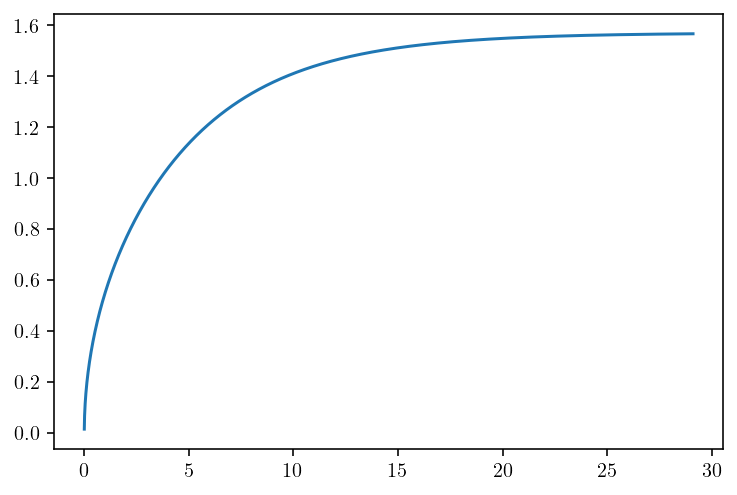

In [490]:
plt.plot(tiempos2, theta_numint_mean_t)

(0, 3)

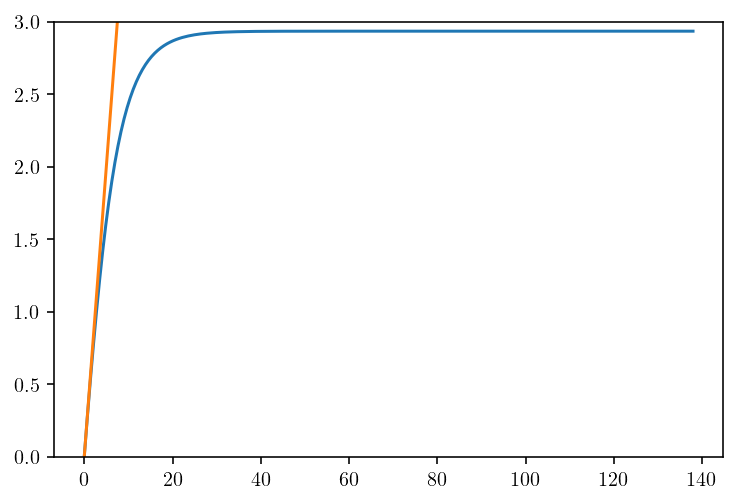

In [172]:
plt.plot(tiempos2, thetasqr_numint_mean_t)
plt.plot(tiempos2, 4*D*np.array(tiempos2))
plt.ylim(0,3)

In [ ]:
plt.plot(tiempos2, theta_num_mean_t)

In [ ]:
4./dt

In [219]:
base_ort_nor(np.array([0,0,1]))

(array([1., 0., 0.]), array([0., 1., 0.]))

In [220]:
phi_uni(0, 0)

array([-0.,  1.,  0.])

In [222]:
phi_uni(0, np.pi/2)

array([-1.000000e+00,  6.123234e-17,  0.000000e+00])

In [223]:
phi_uni(0, np.pi)

array([-1.2246468e-16, -1.0000000e+00,  0.0000000e+00])

In [224]:
phi_uni(0, 3*np.pi/2)

array([ 1.0000000e+00, -1.8369702e-16,  0.0000000e+00])

In [225]:
base_ort_nor(np.array([0,0,-1]))

(array([1., 0., 0.]), array([ 0., -1.,  0.]))

# Kurtosis

In [589]:
from scipy.stats import kurtosis

In [590]:
thetas_array = np.array(thetas)

In [594]:
thetas_array.shape[0]

42001

In [597]:
l_kurtosis = []
for t in range(thetas_array.shape[0]):
    l_kurtosis.append(kurtosis(thetas_array[t]))

In [600]:
kurtosis(thetas_array[1])

0.8484080274303416

In [605]:
len(thetas_array[42000])

10000

In [606]:
len(l_kurtosis)

42001

In [ ]:
len

In [ ]:
fig, ax = plt.subplots(figsize=(7,6))

#ax.spines['bottom'].set_position(-3)

ax.plot(tiempos,l_kurtosis, color='k', alpha=1, linewidth=1)
ax.set_xlabel(r"$t$",fontsize=17)
ax.set_ylabel(r"Kurt$[\theta(t)]$",fontsize=17)
ax.set_xlim(0,15)
ins = inset_axes(ax, 
                        width="30%", # width = 30% of parent_bbox
                        height=1.0, # height : 1 inch
                        loc= 3)
    
ins.plot(tiempos, l_kurtosis, label= 'Numeric', alpha=1.0, linewidth=1.5,
         color = 'k', linestyle='-')
ins.set_xlim(0,5)
ins.set_xlabel(r"$t$", fontsize=12)